## Set up general libraries for Terra

In [1]:
# Use the os package to interact with the environment
import os

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Import seaborn for plots
import seaborn as sns

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

# Import reduce
from functools import reduce


Install openpyxl for reading excel

In [17]:
#!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:0000:0100:01


In [15]:
#!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 7.5 MB/s eta 0:00:00


In [2]:
!pip show openpyxl

Name: openpyxl
Version: 3.0.10
Summary: A Python library to read/write Excel 2010 xlsx/xlsm files
Home-page: https://openpyxl.readthedocs.io
Author: See AUTHORS
Author-email: charlie.clark@clark-consulting.eu
License: MIT
Location: /home/jupyter/.local/lib/python3.7/site-packages
Requires: et-xmlfile
Required-by: 


In [3]:
import sys

sys.path

['/home/jupyter/AMP-PD_Pathway_PRS/edit',
 '/etc/jupyter/custom',
 '/usr/lib/spark/python',
 '/home/jupyter/packages',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/home/jupyter/.local/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/home/jupyter/.ipython']

In [4]:
#Add path where packages are being installed to the sys.paths
sys.path.append('/home/jupyter/.local/lib/python3.7/site-packages')

In [5]:
# Import openpyxl for reading xlsx sheets
import openpyxl

## Set up billing projects and data path variables

In [6]:
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

GS_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
GS_CLINICAL_RELEASE_PATH = f'{GS_RELEASE_PATH}/clinical'

GS_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
GS_WGS_RELEASE_PLINK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'plink')
GS_WGS_RELEASE_GATK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'gatk')

BQ_RELEASE_DATASET = 'amp-pd-research.2021_v2_5release_0510'

print(BILLING_PROJECT_ID)
print(GS_CLINICAL_RELEASE_PATH)
print(GS_WGS_RELEASE_PLINK_PATH)
print(GS_WGS_RELEASE_GATK_PATH)

manuela-norway
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical
gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/plink
gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/gatk


## Set up functions

In [7]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}')
    !$command

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))
    
# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)
    
# Get the data from a query
def bq_query(query):
    """Return the contents of a query against BigQuery"""
    return pd.read_gbq(
        query,
        project_id=BILLING_PROJECT_ID,
        dialect='standard')

## Required Python packages

The following Python packages are required (with in parentheses the versions that were used for the analyses in other cohorts):

* python (3.8.8)
* numpy (1.20.2)
* pandas (1.2.4)
* scipy (1.6.3)
* statsmodels (0.12.2)

In [8]:
import numpy as np
import os
import pandas as pd
from scipy.stats import median_abs_deviation, chi2
import statsmodels.api as sm
import csv

In [9]:
%%bash
ls /home/jupyter

AD_PRS
AD_sumstats
AMP-PD_Pathway_PRS
clinical_data_v2-5
entrypoint.out
gcta_1.93.2beta
gcta_1.93.2beta.zip
genetic_data_v2-5
HY3_results
Johann_PRS
jupyter.log
LDpred2
LICENSE
lost+found
notebooks
packages
pathways
PD_PRS_Nalls2019
plink
plink2
plink2_linux_avx2_20210826.zip
plink_linux_x86_64_20190304.zip
prettify
PRSice_linux
PRSice_linux.zip
PRSice.R
R_packages
SNCA
sumstats
TOY_BASE_GWAS.assoc
toy.map
toy.ped
TOY_TARGET_DATA.bed
TOY_TARGET_DATA.bim
TOY_TARGET_DATA.fam
TOY_TARGET_DATA.pheno
welder.log


## Copy LDpred2 files to workspace

In [5]:
%%bash
mkdir -p /home/jupyter/LDpred2

In [5]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp {WORKSPACE_BUCKET}/LDpred2_output_files.tar.gz /home/jupyter/LDpred2/')

Executing: gsutil -mu manuela-norway cp gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/LDpred2_output_files.tar.gz /home/jupyter/LDpred2/
Copying gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/LDpred2_output_files.tar.gz...
\ [1/1 files][ 25.2 GiB/ 25.2 GiB] 100% Done  55.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/25.2 GiB.                                     


In [ ]:
%%bash

#Uncompress LDpred2 files
#Note that this was initially a .tar file that has been zipped with gzip (rather than all with tar compression)
cd /home/jupyter/LDpred2
gunzip LDpred2_output_files.tar.gz

In [10]:
%%bash
cd /home/jupyter/LDpred2
tar -xvf LDpred2_output_files.tar

LDpred2 output files/
LDpred2 output files/adams_2016__intracranial_volume.txt
LDpred2 output files/chia_2021__lewy_body_dementia.txt
LDpred2 output files/davies_2016__memory_performance.txt
LDpred2 output files/davies_2016__reasoning.txt
LDpred2 output files/davies_2018__reaction_time.txt
LDpred2 output files/grasby_2020__mean_bankssts_surfavg.txt
LDpred2 output files/grasby_2020__mean_bankssts_thickavg.txt
LDpred2 output files/grasby_2020__mean_caudalanteriorcingulate_surfavg.txt
LDpred2 output files/grasby_2020__mean_caudalanteriorcingulate_thickavg.txt
LDpred2 output files/grasby_2020__mean_caudalmiddlefrontal_surfavg.txt
LDpred2 output files/grasby_2020__mean_caudalmiddlefrontal_thickavg.txt
LDpred2 output files/grasby_2020__mean_cuneus_surfavg.txt
LDpred2 output files/grasby_2020__mean_cuneus_thickavg.txt
LDpred2 output files/grasby_2020__mean_entorhinal_surfavg.txt
LDpred2 output files/grasby_2020__mean_entorhinal_thickavg.txt
LDpred2 output files/grasby_2020__mean_frontalpole_s

In [14]:
%%bash
cd /home/jupyter/LDpred2

#Rename the folder to remove spaces
mv 'LDpred2 output files' LDpred2_output_files

adams_2016__intracranial_volume.txt
chia_2021__lewy_body_dementia.txt
davies_2016__memory_performance.txt
davies_2016__reasoning.txt
davies_2018__reaction_time.txt
grasby_2020__mean_bankssts_surfavg.txt
grasby_2020__mean_bankssts_thickavg.txt
grasby_2020__mean_caudalanteriorcingulate_surfavg.txt
grasby_2020__mean_caudalanteriorcingulate_thickavg.txt
grasby_2020__mean_caudalmiddlefrontal_surfavg.txt
grasby_2020__mean_caudalmiddlefrontal_thickavg.txt
grasby_2020__mean_cuneus_surfavg.txt
grasby_2020__mean_cuneus_thickavg.txt
grasby_2020__mean_entorhinal_surfavg.txt
grasby_2020__mean_entorhinal_thickavg.txt
grasby_2020__mean_frontalpole_surfavg.txt
grasby_2020__mean_frontalpole_thickavg.txt
grasby_2020__mean_full_surfarea.txt
grasby_2020__mean_full_thickness.txt
grasby_2020__mean_fusiform_surfavg.txt
grasby_2020__mean_fusiform_thickavg.txt
grasby_2020__mean_inferiorparietal_surfavg.txt
grasby_2020__mean_inferiorparietal_thickavg.txt
grasby_2020__mean_inferiortemporal_surfavg.txt
grasby_202

mv: cannot stat 'LDpred2 output files': No such file or directory


In [7]:
%%bash
ls /home/jupyter/LDpred2

LDpred2_output_files
LDpred2_output_files.tar
LDpred2_output_files.tar.gz


## Computing all the polygenic risk scores

For each phenotype, LDpred2 outputs a text file whose first column corresponds to the variant ID and the remaining columns correspond to the coefficients associated to each variant for different values of $p$, which is the proportion of causal variants.

To compute all the polygenic risk scores, one just has to compute the dot product between the individual-level genetic data (the bfiles) and each column in each LDpred2 file.
According to the [Allelic scoring](https://www.cog-genomics.org/plink/1.9/score) documentation, `PLINK` has a `--score` flag that allows for computing such linear scoring.

The `--score` flag requires 3 columns in the input file (the file with the coefficients):

* variant IDs 
* allele codes
* scores

What is nice is that, since allele codes (i.e., the effect alleles) are required, there is no need to change the signs of the coefficients for variants that need reversing.

I reformatted the LDpred2 output files so that:

* **variant IDs** corresponds to column 1.
* **allele codes** corresponds to column 2.
* **scores** correspond to columns ranging from 3 to 32.

In [8]:
%%bash

# Path to the directory containing the LDpred2 files
PATH_TO_LDPRED2_FILES="/home/jupyter/LDpred2/LDpred2_output_files/*"

# Path to the bed/bim/fam files (with the prefix)
PATH_TO_BFILE=/home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf 

for file in $PATH_TO_LDPRED2_FILES
do
    for nGRS in {1..30}
    do
        /home/jupyter/plink \
        --bfile $PATH_TO_BFILE \
        --score $PATH_TO_LDPRED2_FILES/$file 1 2 $((nGRS + 2)) sum \
        --out $PATH_TO_LDPRED2_FILES/$file__grs$nGRS
    done
done

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CalledProcessError: Command 'b'\n# Path to the directory containing the LDpred2 files\nPATH_TO_LDPRED2_FILES="/home/jupyter/LDpred2/LDpred2_output_files/*"\n\n# Path to the bed/bim/fam files (with the prefix)\nPATH_TO_BFILE=/home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf \n\nfor file in $PATH_TO_LDPRED2_FILES\ndo\n    for nGRS in {1..30}\n    do\n        /home/jupyter/plink \\\n        --bfile $PATH_TO_BFILE \\\n        --score $PATH_TO_LDPRED2_FILES/$file 1 2 $((nGRS + 2)) sum \\\n        --out $PATH_TO_LDPRED2_FILES/$file__grs$nGRS\n    done\ndone\n'' returned non-zero exit status 2.

In [9]:
%%bash
ls /home/jupyter/LDpred2/LDpred2_output_files

adams_2016__intracranial_volume.txt
adams_2016__intracranial_volume.txt__grs10.log
adams_2016__intracranial_volume.txt__grs10.profile
adams_2016__intracranial_volume.txt__grs11.log
adams_2016__intracranial_volume.txt__grs11.profile
adams_2016__intracranial_volume.txt__grs12.log
adams_2016__intracranial_volume.txt__grs12.profile
adams_2016__intracranial_volume.txt__grs13.log
adams_2016__intracranial_volume.txt__grs13.profile
adams_2016__intracranial_volume.txt__grs14.log
adams_2016__intracranial_volume.txt__grs14.profile
adams_2016__intracranial_volume.txt__grs15.log
adams_2016__intracranial_volume.txt__grs15.profile
adams_2016__intracranial_volume.txt__grs16.log
adams_2016__intracranial_volume.txt__grs16.profile
adams_2016__intracranial_volume.txt__grs17.log
adams_2016__intracranial_volume.txt__grs17.profile
adams_2016__intracranial_volume.txt__grs18.log
adams_2016__intracranial_volume.txt__grs18.profile
adams_2016__intracranial_volume.txt__grs19.log
adams_2016__intracranial_volume.txt

## Get cohort information

In [16]:
cohort_query = f"""

SELECT
participant_id, study
FROM `{BQ_RELEASE_DATASET}.amp_pd_participants`

"""

cohort = bq_query(cohort_query)

In [17]:
cohort.study.value_counts()

LBD        4586
PPMI       1945
PDBP       1606
HBS        1189
LCC         638
Steady      334
Sure        261
BioFIND     213
Name: study, dtype: int64

In [18]:
#Write full file as output
with open('/home/jupyter/clinical_data_v2-5/cohort.tab', 'w') as f:
    f.write(cohort.to_csv(index=False, sep='\t'))

In [19]:
cohorts = ["LBD", "PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

#Loop over cohorts - select just individuals in each cohort and write as separate output
#This is so we can extract each cohort individuals from plink or PRSice2 files
for COHORT in cohorts:
    cohort_select = cohort.copy()
    cohort_select = cohort_select[cohort_select['study'] == COHORT]
    print(COHORT)
    
    with open(f'/home/jupyter/clinical_data_v2-5/{COHORT}.tab', 'w') as f:
        f.write(cohort_select.to_csv(index=False, sep='\t'))

LBD
PPMI
PDBP
HBS
LCC
Steady
Sure
BioFIND


In [21]:
cohort_select.head()

participant_id    study
0        BF-1001  BioFIND
1        BF-1002  BioFIND
2        BF-1003  BioFIND
3        BF-1004  BioFIND
4        BF-1005  BioFIND

## Computing the final polygenic risk scores

The LDpred2 model makes the assumption that only a proportion of variants, denoted $p$, are causal.
`LDpred2-auto` computes polygenic risk scores for several values of $p$ ($30$ by default) and only the values of $p$ that give non-outlying polygenic risk scores are kept.

Let `df` be the matrix with shape `(n_subjects, 30)` whose rows consist of the 30 PRSs for each subject. The following steps are performed (see the [code in the original LDpred2 tutorial](https://github.com/privefl/paper-ldpred2/blob/b4caeac2a4e0754910ac2703b845ff79266bb184/code/run-ldpred2-gwide.R#L110-L112)):

1. The standard deviation of each column is computed. Let $sd$ be the corresponding vector of length $30$.
2. The columns to keep are the ones matching the following criterion:
$$
\left\{ i | \text{abs}( sd_{i} - \text{median}(sd)) < 3 \times \text{median_absolute_deviation}(sd) \right\}
$$
3. The final PRS is simply computed as the mean of the included columns.

The following Python function allows for computing the final polygenic risk score for each subject.

In [6]:
def compute_final_polygenic_risk_scores(df):
    """Compute the final polygenic risk scores.
    
    Parameters
    ----------
    df : DataFrame, shape = (n_subjects, 30)
        Matrix containing the 30 PRS for each subject.
        
    Returns
    -------
    x : array, shape = (n_subjects, )
        Vector containing the final PRS for each subject
    
    """
    # Filter out outlying scores
    sd = df.std(axis=0)
    to_keep = np.abs(sd - np.median(sd)) < 3 * median_abs_deviation(sd)
    
    # Return the mean PRS for the included PRSs
    return df[df.columns[to_keep]].mean(axis=1)

Make directory to store final PRS dataframes for each cohort

In [11]:
%%bash

#Make directory to store PRSs and results
mkdir -p /home/jupyter/Johann_PRS

Since this process needs to be performed for all the phenotypes, it could be done using a `for` loop by listing all the files in the corresponding directory:

I have edited this slightly to separate each cohort. So the PRSs are combined and outliers removed within each cohort.

In [98]:
path_ldpred2_files = "/home/jupyter/LDpred2/LDpred2_output_files/"
files = [file for file in os.listdir(path_ldpred2_files) if file.endswith('.txt')]

cohorts = ["LBD", "PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:
    
    #Make empty dataframe
    df_grs = []
    
    for file in files:
        df_grs_phenotype = pd.concat(
            [pd.read_csv(os.path.join(path_ldpred2_files, file + f'__grs{i}.profile'),
                     sep='\s+', usecols=[1, 5], index_col=0)
             for i in range(1, 31)],
            axis=1
        )
        
        #Read in individuals for cohort
        cohort_individuals = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/{cohort}.tab', 
                             sep = "\t", usecols = ['participant_id'])

        #Set index as participant_id
        cohort_individuals = cohort_individuals.set_index('participant_id')

        #Merge with PRS data
        merged = pd.merge(df_grs_phenotype, cohort_individuals, left_index = True, right_index = True, how = 'inner')
        
        #If merged dataframe is empty (e.g. LBD cohort because we are only including PD cases)
        if merged.empty:
            continue
            
        else:
            
            #Standardise
            df_grs.append(compute_final_polygenic_risk_scores(merged))
            
            
    if merged.empty:
        print(f'{cohort} dataFrame is empty!')
    
    else:
        #After standardising each PRS, join each PRS to create main file
        df_grs = pd.concat(df_grs, axis=1)
        df_grs.columns = ['GRS__' + file.split('.')[0] for file in files]
        
        #Print message
        print(f'Processing {cohort}...')

        #Save for each cohort
        with open(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab', 'w') as f:
            f.write(df_grs.to_csv(index=True, sep='\t'))

LBD dataFrame is empty!
Processing PPMI...
Processing PDBP...
Processing HBS...
Processing LCC...
Processing Steady...
Processing Sure...
Processing BioFIND...


## Get age at diagnosis data

Query clinical data

In [29]:
age_dx_query = f"""

SELECT 
*
FROM `{BQ_RELEASE_DATASET}.PD_Medical_History`

"""

age_dx = bq_query(age_dx_query)

In [1]:
#Check STEADY-PD participants - they seem to be all missing age at diagnosis
#age_dx[age_dx.participant_id.str.contains("SY")]

In [18]:
#age_dx[age_dx.participant_id == "BF-1002"]

In [31]:
#First remove rows missing age at diagnosis
age_dx_nomiss = age_dx[age_dx['age_at_diagnosis'].notnull()]

In [19]:
#age_dx_nomiss.head()

Note there are some individuals who report different age at diagnosis at different visits. Here we want to take the most frequently reported age at diagnosis

In [ ]:
#Now get the most frequent age at diagnosis reported for each participant (the mode)
age_dx_nomiss_nodupli = age_dx_nomiss.groupby('participant_id').age_at_diagnosis.agg(lambda x : x.mode()[0])

#age_dx_nomiss_nodupli.head()

Extract just PD cases (PD at study entry and latest diagnosis, excluding known genetic PD cases). This is the same list of individuals we have extracted from the genetic data

In [ ]:
PDcases_nongenetic = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_nongenetic.tab',
                 delimiter="\t")

PDcases_agedx = pd.merge(PDcases_nongenetic, age_dx_nomiss_nodupli, left_on='FID', right_on='participant_id', how = 'left')

#PDcases_agedx.head()


Check if there are any cases missing age at diagnosis

In [22]:
#PDcases_agedx[PDcases_agedx['age_at_diagnosis'].isnull()]

In [42]:
#Write as output
with open('/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab', 'w') as f:
    f.write(PDcases_agedx.to_csv(index=False, sep='\t'))

## Calculate APOE alleles

In [26]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf \
        --snps 19:44908684:T:C 19:44908822:C:T \
        --recodeA \
        --out /home/jupyter/genetic_data_v2-5/APOE')

Executing: /home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf         --snps 19:44908684:T:C 19:44908822:C:T         --recodeA         --out /home/jupyter/genetic_data_v2-5/APOE
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recodeA flag deprecated.  Use 'recode A ...'.
Logging to /home/jupyter/genetic_data_v2-5/APOE.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf
  --out /home/jupyter/genetic_data_v2-5/APOE
  --recode A
  --snps 19:44908684:T:C 19:44908822:C:T

60292 MB RAM detected; reserving 30146 MB for main workspace.
7737986 variants loaded from .bim file.
2610 people (1659 males, 951 females)

## Calculate GBA mutations

Extract all variants within GBA gene boundaries (chr1:155,234,452-155,244,670, from UCSC Genome Browser hg38).

This is done before MAF filtering to capture rare variants.

In [48]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe \
        --chr 1 \
        --from-bp 155234452 \
        --to-bp 155244670 \
        --make-bed \
        --out /home/jupyter/genetic_data_v2-5/GBA')

Executing: /home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe         --chr 1         --from-bp 155234452         --to-bp 155244670         --make-bed         --out /home/jupyter/genetic_data_v2-5/GBA
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/genetic_data_v2-5/GBA.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe
  --chr 1
  --from-bp 155234452
  --make-bed
  --out /home/jupyter/genetic_data_v2-5/GBA
  --to-bp 155244670

60292 MB RAM detected; reserving 30146 MB for main workspace.
79 out of 27506133 variants loaded from .bim file.
2610 people (1659 males, 951 females) loaded from .fam.


In [60]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/GBA \
        --freq \
        --out /home/jupyter/genetic_data_v2-5/GBA.freq')

Executing: /home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/GBA         --freq         --out /home/jupyter/genetic_data_v2-5/GBA.freq
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/genetic_data_v2-5/GBA.freq.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/GBA
  --freq
  --out /home/jupyter/genetic_data_v2-5/GBA.freq

60292 MB RAM detected; reserving 30146 MB for main workspace.
79 variants loaded from .bim file.
2610 people (1659 males, 951 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2610 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
--freq: Allele fr

In [50]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/GBA \
        --recodeA \
        --out /home/jupyter/genetic_data_v2-5/GBA.recodeA')

Executing: /home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/GBA         --recodeA         --out /home/jupyter/genetic_data_v2-5/GBA.recodeA
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recodeA flag deprecated.  Use 'recode A ...'.
Logging to /home/jupyter/genetic_data_v2-5/GBA.recodeA.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/GBA
  --out /home/jupyter/genetic_data_v2-5/GBA.recodeA
  --recode A

60292 MB RAM detected; reserving 30146 MB for main workspace.
79 variants loaded from .bim file.
2610 people (1659 males, 951 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2610 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757

Copy GBA variant list bim file to workspace bucket

In [61]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/genetic_data_v2-5/GBA.bim {WORKSPACE_BUCKET}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/genetic_data_v2-5/GBA.freq.frq {WORKSPACE_BUCKET}')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/genetic_data_v2-5/GBA.bim gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181
Copying file:///home/jupyter/genetic_data_v2-5/GBA.bim [Content-Type=application/octet-stream]...
/ [1 files][  2.6 KiB/  2.6 KiB]                                                
Operation completed over 1 objects/2.6 KiB.                                      
Executing: gsutil -u manuela-norway cp -r /home/jupyter/genetic_data_v2-5/GBA.freq.frq gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181
Copying file:///home/jupyter/genetic_data_v2-5/GBA.freq.frq [Content-Type=application/octet-stream]...
/ [1 files][  4.3 KiB/  4.3 KiB]                                                
Operation completed over 1 objects/4.3 KiB.                                      


## Code GBA mutations as mild/severe/undetermined

Copy spreadsheet with annotated GBA variants from workspace bucket to notebook

In [9]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp {WORKSPACE_BUCKET}/GBA_vars_annotated.xlsx /home/jupyter/genetic_data_v2-5/')

Executing: gsutil -mu manuela-norway cp gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/GBA_vars_annotated.xlsx /home/jupyter/genetic_data_v2-5/
Copying gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/GBA_vars_annotated.xlsx...
/ [1/1 files][ 27.0 KiB/ 27.0 KiB] 100% Done                                    
Operation completed over 1 objects/27.0 KiB.                                     


In [23]:
#Read in GBA raw data
GBA = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/GBA.recodeA.raw', sep = " ")

#Read in annotated GBA variants
GBA_annotated = pd.read_excel(f'/home/jupyter/genetic_data_v2-5/GBA_vars_annotated.xlsx')

In [24]:
GBA_annotated.head()

chr              SNP         bp A1 A2      Freq         rsID  \
0    1  1:155235196:G:A  155235196  A  G  0.000383   rs80356771   
1    1  1:155235203:C:G  155235203  G  C  0.001724    rs1135675   
2    1  1:155235217:C:G  155235217  G  C  0.001149     rs368060   
3    1  1:155235227:G:A  155235227  A  G  0.000000  rs149257166   
4    1  1:155235409:G:T  155235409  T  G  0.002299  rs183510604   

  Variant_legacyname Variant (gnomAD) - VEP annotation  \
0             ﻿R463C                             R502C   
1                NaN                             V499V   
2                NaN                             A495P   
3                NaN                             P491P   
4                NaN               intron c.1389-98C>A   

  designation_oldGBAtable               clinvar  \
0                  Severe            Pathogenic   
1                     NaN  benign/likely benign   
2                     NaN                benign   
3                     NaN         likely benign   
4                     NaN                   NaN   

                                        clinvar_link  \
0  https://www.ncbi.nlm.nih.gov/clinvar/variation...   
1  https://www.ncbi.nlm.nih.gov/clinvar/variation...   
2  https://www.ncbi.nlm.nih.gov/clinvar/variation...   
3  https://www.ncbi.nlm.nih.gov/clinvar/variation...   
4                                                NaN   

  GBA_table https://link.springer.com/article/10.1007/s00702-022-02511-7/tables/1  \
0                                             Severe                                
1                                                NaN                                
2        Severe but only in combination with p.L483P                                
3                                                NaN                                
4                                                NaN                                

  Notes  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

In [25]:
GBA_annotated['GBA_table https://link.springer.com/article/10.1007/s00702-022-02511-7/tables/1'].value_counts()

VUS                                            4
Severe                                         3
Risk                                           2
Severe but only in combination with p.L483P    1
Mild                                           1
Name: GBA_table https://link.springer.com/article/10.1007/s00702-022-02511-7/tables/1, dtype: int64

In [28]:
#Code GBA mutations as mild/severe/undetermined - using second last column GBA_table
GBA_annotated2 = GBA_annotated.copy()
GBA_annotated2['GBA_severity'] = GBA_annotated2['GBA_table https://link.springer.com/article/10.1007/s00702-022-02511-7/tables/1'].map({np.nan: 'undetermined',
                                                                                                                                       'Severe': 'severe',
                                                                                                                                       'VUS': 'undetermined',
                                                                                                                                       'Risk': 'mild',
                                                                                                                                       'Severe but only in combination with p.L483P': 'undetermined',
                                                                                                                                       'Mild': 'mild'})

#Select relevant columns
GBA_annotated2 = GBA_annotated2.loc[:, ['chr', 'SNP', 'bp', 'rsID', 'GBA_severity']]

In [27]:
GBA_annotated2['GBA_severity'].value_counts()

undetermined    73
severe           3
mild             3
Name: GBA_severity, dtype: int64

In [29]:
GBA_annotated2.head()

chr              SNP         bp         rsID  GBA_severity
0    1  1:155235196:G:A  155235196   rs80356771        severe
1    1  1:155235203:C:G  155235203    rs1135675  undetermined
2    1  1:155235217:C:G  155235217     rs368060  undetermined
3    1  1:155235227:G:A  155235227  rs149257166  undetermined
4    1  1:155235409:G:T  155235409  rs183510604  undetermined

For each mutation group (mild/severe/undetermined), write the list of SNP names to extract from genetic dataset.

In [31]:
severe_GBA = GBA_annotated2.copy()
severe_GBA = severe_GBA[severe_GBA.GBA_severity == "severe"]
severe_GBA = severe_GBA.loc[:, ['SNP']]

#Write as output
with open('/home/jupyter/genetic_data_v2-5/severe_GBA.tab', 'w') as f:
    f.write(severe_GBA.to_csv(index=False, sep='\t'))

In [35]:
mild_GBA = GBA_annotated2.copy()
mild_GBA = mild_GBA[mild_GBA.GBA_severity == "mild"]
mild_GBA = mild_GBA.loc[:, ['SNP']]

#Write as output
with open('/home/jupyter/genetic_data_v2-5/mild_GBA.tab', 'w') as f:
    f.write(mild_GBA.to_csv(index=False, sep='\t'))

In [36]:
undetermined_GBA = GBA_annotated2.copy()
undetermined_GBA = undetermined_GBA[undetermined_GBA.GBA_severity == "undetermined"]
undetermined_GBA = undetermined_GBA.loc[:, ['SNP']]

#Write as output
with open('/home/jupyter/genetic_data_v2-5/undetermined_GBA.tab', 'w') as f:
    f.write(undetermined_GBA.to_csv(index=False, sep='\t'))

Extract severe GBA mutations only and recode

In [37]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe \
        --extract /home/jupyter/genetic_data_v2-5/severe_GBA.tab \
        --recodeA \
        --out /home/jupyter/genetic_data_v2-5/severe_GBA.recodeA')

Executing: /home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe         --extract /home/jupyter/genetic_data_v2-5/severe_GBA.tab         --recodeA         --out /home/jupyter/genetic_data_v2-5/severe_GBA.recodeA
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recodeA flag deprecated.  Use 'recode A ...'.
Logging to /home/jupyter/genetic_data_v2-5/severe_GBA.recodeA.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe
  --extract /home/jupyter/genetic_data_v2-5/severe_GBA.tab
  --out /home/jupyter/genetic_data_v2-5/severe_GBA.recodeA
  --recode A

3679 MB RAM detected; reserving 1839 MB for main workspace.
27506133 

Extract mild GBA mutations and recode

In [39]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe \
        --extract /home/jupyter/genetic_data_v2-5/mild_GBA.tab \
        --recodeA \
        --out /home/jupyter/genetic_data_v2-5/mild_GBA.recodeA')

Executing: /home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe         --extract /home/jupyter/genetic_data_v2-5/mild_GBA.tab         --recodeA         --out /home/jupyter/genetic_data_v2-5/mild_GBA.recodeA
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recodeA flag deprecated.  Use 'recode A ...'.
Logging to /home/jupyter/genetic_data_v2-5/mild_GBA.recodeA.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe
  --extract /home/jupyter/genetic_data_v2-5/mild_GBA.tab
  --out /home/jupyter/genetic_data_v2-5/mild_GBA.recodeA
  --recode A

3679 MB RAM detected; reserving 1839 MB for main workspace.
27506133 variants l

Extract unknown GBA mutations and recode

In [40]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe \
        --extract /home/jupyter/genetic_data_v2-5/undetermined_GBA.tab \
        --recodeA \
        --out /home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA')

Executing: /home/jupyter/plink --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe         --extract /home/jupyter/genetic_data_v2-5/undetermined_GBA.tab         --recodeA         --out /home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recodeA flag deprecated.  Use 'recode A ...'.
Logging to /home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe
  --extract /home/jupyter/genetic_data_v2-5/undetermined_GBA.tab
  --out /home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA
  --recode A

3679 MB RAM detected; reserving 1839 MB

In [64]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw {WORKSPACE_BUCKET}')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181
Copying file:///home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw [Content-Type=application/octet-stream]...
/ [1 files][464.0 KiB/464.0 KiB]                                                
Operation completed over 1 objects/464.0 KiB.                                    


## Calculate genetic Principal Components within each cohort

Generate genetic PCs in each cohort separately. Excluding LBD as we excluded these samples from the genetic dataset.

First prune for independent SNPs.

In [5]:
%%bash

for COHORT in PPMI PDBP HBS LCC Steady Sure BioFIND
do
/home/jupyter/plink2 --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf \
                --keep-fam /home/jupyter/clinical_data_v2-5/"$COHORT".tab \
                --indep-pairwise 50 5 0.01 \
                --out /home/jupyter/genetic_data_v2-5/"$COHORT".pruning \
                --threads 16
done

PLINK v2.00a3LM AVX2 Intel (26 Aug 2021)       www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/genetic_data_v2-5/PPMI.pruning.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf
  --indep-pairwise 50 5 0.01
  --keep-fam /home/jupyter/clinical_data_v2-5/PPMI.tab
  --out /home/jupyter/genetic_data_v2-5/PPMI.pruning
  --threads 16

Start time: Thu Jun 23 08:51:25 2022
60292 MiB RAM detected; reserving 30146 MiB for main workspace.
Using up to 16 threads (change this with --threads).
2610 samples (951 females, 1659 males; 2610 founders) loaded from
/home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf.fam.
7737986 variants loaded from
/home/jupyter/genetic_data_v2-5/m

Extract independent SNPs

In [43]:
%%bash

for COHORT in PPMI PDBP HBS LCC Steady Sure BioFIND
do
/home/jupyter/plink2 --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf \
                --keep-fam /home/jupyter/clinical_data_v2-5/"$COHORT".tab \
                --extract /home/jupyter/genetic_data_v2-5/"$COHORT".pruning.prune.in \
                --make-bed \
                --out /home/jupyter/genetic_data_v2-5/"$COHORT".pruned \
                --threads 16
done

PLINK v2.00a3LM AVX2 Intel (26 Aug 2021)       www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/genetic_data_v2-5/PPMI.pruned.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf
  --extract /home/jupyter/genetic_data_v2-5/PPMI.pruning.prune.in
  --keep-fam /home/jupyter/clinical_data_v2-5/PPMI.tab
  --make-bed
  --out /home/jupyter/genetic_data_v2-5/PPMI.pruned
  --threads 16

Start time: Thu Jun 23 09:18:05 2022
60292 MiB RAM detected; reserving 30146 MiB for main workspace.
Using up to 16 threads (change this with --threads).
2610 samples (951 females, 1659 males; 2610 founders) loaded from
/home/jupyter/genetic_data_v2-5/merged.PDonly.updated_sex.mind_0.05.het.binary.xsplit.nongenetic.no_dupli.auto_snps.european.pihat.geno.missing_hap.hwe.maf.fam.
7737986 varian

Run PCA on independent SNPs

In [44]:
%%bash

for COHORT in PPMI PDBP HBS LCC Steady Sure BioFIND
do
/home/jupyter/plink2 --bfile /home/jupyter/genetic_data_v2-5/"$COHORT".pruned \
                --pca \
                --out /home/jupyter/genetic_data_v2-5/"$COHORT".pca \
                --threads 16
done

PLINK v2.00a3LM AVX2 Intel (26 Aug 2021)       www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/genetic_data_v2-5/PPMI.pca.log.
Options in effect:
  --bfile /home/jupyter/genetic_data_v2-5/PPMI.pruned
  --out /home/jupyter/genetic_data_v2-5/PPMI.pca
  --pca
  --threads 16

Start time: Thu Jun 23 09:18:38 2022
60292 MiB RAM detected; reserving 30146 MiB for main workspace.
Using up to 16 threads (change this with --threads).
465 samples (165 females, 300 males; 465 founders) loaded from
/home/jupyter/genetic_data_v2-5/PPMI.pruned.fam.
162495 variants loaded from /home/jupyter/genetic_data_v2-5/PPMI.pruned.bim.
Note: No phenotype data present.
Calculating allele frequencies... 0%40%80%done.
Constructing GRM: 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%

## Get MoCA data

Query MoCA data

In [131]:
moca_query = f"""

SELECT 
*
FROM `{BQ_RELEASE_DATASET}.MOCA`
"""
moca = bq_query(moca_query)

In [23]:
#moca.head()

Note that there is no data on individual items, so will just use the total score - assume this has already been adjusted for education.

In [133]:
#Arrange by participant ID and visit month and select relevant columns
moca = moca.sort_values(by = ['participant_id', 'visit_month'])
moca = moca.loc[:, ['participant_id', 'visit_name', 'visit_month', 'moca_total_score']]

In [135]:
#Remove duplicated visit entries - rows with #
moca_nodupli = moca.copy()
moca_nodupli = moca_nodupli[~moca_nodupli.visit_name.str.contains('#')]

In [24]:
#Check for any other duplicated entries by participant id and visit month
#moca_nodupli[moca_nodupli.duplicated(['participant_id', 'visit_month'], keep = False)]

In [137]:
#There are still a few individuals with duplicated entries by participant_id and visit_month with different MoCA scores
#Just keep the first datapoint
moca_nodupli_final = moca_nodupli.copy()
moca_nodupli_final = moca_nodupli_final.drop_duplicates(subset = ['participant_id', 'visit_month'], keep = 'first')

In [138]:
#Write as output
with open('/home/jupyter/clinical_data_v2-5/moca_allparticipants.tab', 'w') as f:
    f.write(moca_nodupli_final.to_csv(index=False, sep='\t'))

## Get education data

In [20]:
edu_query = f"""

SELECT 
*
FROM `{BQ_RELEASE_DATASET}.Demographics`
"""
edu = bq_query(edu_query)

In [25]:
#edu.head()

In [22]:
edu.education_level_years.value_counts()

12-16 years              3709
Greater than 16 years    2003
Unknown                   569
Less than 12 years        357
0 years                     2
Name: education_level_years, dtype: int64

In [23]:
#Arrange by participant ID and visit month and select relevant columns
edu = edu.sort_values(by = ['participant_id', 'visit_month'])

In [2]:
#Check for duplicates
#edu[edu.duplicated(subset = ['participant_id'])]
#Note that the data is still in long format

In [3]:
#edu.head()

In [26]:
#Remove duplicates keeping just the first value
edu_nodupli = edu.copy()
edu_nodupli = edu_nodupli.drop_duplicates(subset = ['participant_id'], keep = 'first')

In [4]:
#edu_nodupli.head()

In [52]:
#Select just relevant columns - participant ID and education
edu_nodupli_final = edu_nodupli.copy()
edu_nodupli_final = edu_nodupli_final[['participant_id', 'education_level_years']]
#Add column for FID which is the participant_id
edu_nodupli_final['FID'] = edu_nodupli_final['participant_id']
#Rename participant_id column as IID - this is so we can merge with the other datasets later
edu_nodupli_final = edu_nodupli_final.rename(columns = {"participant_id":"IID"})

In [53]:
edu_nodupli_final.shape

(10772, 3)

In [5]:
#edu_nodupli_final.head()

In [ ]:
edu_nodupli_final = edu_nodupli_final[['FID', 'IID', 'education_level_years']]
#edu_nodupli_final.head()

In [57]:
#Write as output. Note that this is from all participants not just PD patients
with open('/home/jupyter/clinical_data_v2-5/edu_allparticipants.tab', 'w') as f:
    f.write(edu_nodupli_final.to_csv(index=False, sep='\t'))

## Investigating the statistical association between each PRS and cognitive scores using mixed effects models: MoCA

We are interested in the $\beta$ coefficient associated to each PRS in order to see if it is statistically different from $0$ and, if so, its sign (positive or negative association).

The exogeneous variables are:
* Age at PD diagnosis
* Sex
* Visit number / timestamp of each visit
* Genetic ancestry (first four principal components)
* APOE status: number of alleles for SNPs rs429358 and rs7412 (I used the number of C alleles because they correspond to APOE $\epsilon$4, but it does not matter if you count the other allele).
* GBA status: number of GBA mutations for different categories based on the severity of these mutations: mild, severe, undetermined.

The following function assumes that the columns of the DataFrame have the following names:

* Endogeneous variable: **'Cognitive score'**
* Exogeneous variables: **'Age at PD diagnosis'**, **'Sex'**, **'Visit'**, **'PC1'**, **'PC2'**, **'PC3'**, **'PC4'**
* Other exogeneous variables (APOE and GBA): **rs429358**, **rs7412**, **Number of severe GBA mutations**, **Number of mild GBA mutations**, **Number of undetermined GBA mutations**
* Group variable: **Patient ID**
* Polygenic risk scores: **'GRS__*'** (that is each name must start with **'GRS__'**)

In [55]:
%%bash
ls /home/jupyter/Johann_PRS/

BioFIND_cogimpairment.tab
BioFIND_PRS_final.tab
HBS_cogimpairment.tab
HBS_PRS_final.tab
LCC_cogimpairment.tab
LCC_demographics.tab
LCC_MoCA_results.tab
LCC_MoCA_results_updated.tab
LCC_PRS_final.tab
LDpred2_PRS.tab
PDBP_cogimpairment.tab
PDBP_demographics.tab
PDBP_MoCA_results.tab
PDBP_MoCA_results_updated.tab
PDBP_PRS_final.tab
PPMI_cogimpairment.tab
PPMI_demographics.tab
PPMI_MoCA_results.tab
PPMI_MoCA_results_updated.tab
PPMI_PRS_final.tab
Steady_cogimpairment.tab
Steady_PRS_final.tab
Sure_cogimpairment.tab
Sure_demographics.tab
Sure_MoCA_results.tab
Sure_MoCA_results_updated.tab
Sure_PRS_final.tab


In [120]:
%%bash
#Make new directory to save residuals plots
mkdir /home/jupyter/Johann_PRS/residuals

In [7]:
def run_statistical_analyses(df):
    """Run the statistical analyses.
    
    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores
        
    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value
    
    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Create a list to save the results for this PRS
        res_single_grs = []
        
        #If the number of severe GBA mutations is all 0, drop this from list of exog variables
        if df_copy['Number of severe GBA mutations'].sum() == 0:
            # Define the exogeneous variables excluding GBA severe
            exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Visit'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358', 'rs7412'] +
            ['Number of mild GBA mutations',
             'Number of undetermined GBA mutations'] +
            [col]
        )
        
        else:
    
            # Define the exogeneous variables including severe GBA mutations
            exog = (
                ['Intercept', 'Age at PD diagnosis', 'Sex', 'Visit'] +
                [f'PC{i}' for i in range(1, 5)] +
                ['rs429358', 'rs7412'] +
                ['Number of severe GBA mutations', 'Number of mild GBA mutations',
                 'Number of undetermined GBA mutations'] +
                [col]
            )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )
    
    return df_res

**Run updated analyses after peer-reviews**

The reviewers asked for two main changes in the analyses:

* Replacing the `Visit` variable with Time since PD onset variable
* Adding an `Education level` variable as a covariate
* Plotting the residuals to check for normality

In [8]:
def run_statistical_analyses_updated(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores
        
    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value
    
    """

    # Create an empty list to save all the results
    df_res = []
    
    # Create an empty dictionary to save the residuals
    residuals = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358', 'rs7412'] +
            ['Number of severe GBA mutations', 'Number of mild GBA mutations',
             'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        print(model.summary())
        
        # Save the residuals
        residuals[col] = df_copy['Cognitive score'] - model.fittedvalues

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )
    
    return df_res, residuals

In [9]:
def run_statistical_analyses_updated_noGBA(df):
    """Run the statistical analyses WITHOUT SEVERE GBA MUTS.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores
        
    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value
    
    """

    # Create an empty list to save all the results
    df_res = []
    
    # Create an empty dictionary to save the residuals
    residuals = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358', 'rs7412'] +
            ['Number of mild GBA mutations',
             'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        print(model.summary())
        
        # Save the residuals
        residuals[col] = df_copy['Cognitive score'] - model.fittedvalues

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )
    
    return df_res, residuals

In [10]:
def plot_residuals(residuals, col, title=''):
    ax = sns.histplot(residuals[col], stat='density', kde=True)
    _ = ax.set_ylabel('');
    _ = ax.set_xlabel('Residuals')
    _ = ax.set_title(title)

Read in all clinical data, genetic PCs and APOE data, and merge.

Analysing PPMI (2755, 15) ...
                        Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Cognitive score
No. Observations:          2755            Method:                     REML           
No. Groups:                465             Scale:                      3.7932         
Min. group size:           1               Log-Likelihood:             -6206.7125     
Max. group size:           10              Converged:                  Yes            
Mean group size:           5.9                                                        
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                   31.412    0.964 32.587 0.000 29.523 33.301
Age at PD diagnosis                   

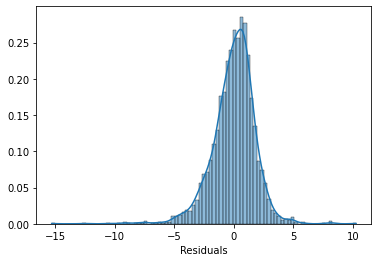

Plotting residuals for GRS__lee_2018__educational_attainment in PPMI


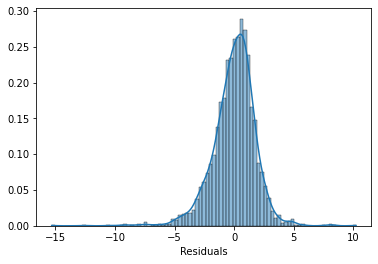

Plotting residuals for GRS__davies_2016__reasoning in PPMI


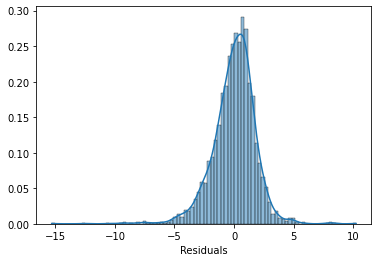

Plotting residuals for GRS__lee_2018__cognitive_performance in PPMI


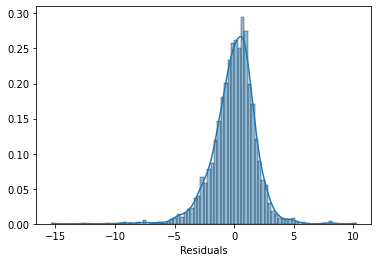

Plotting residuals for GRS__grasby_2020__mean_middletemporal_surfavg in PPMI


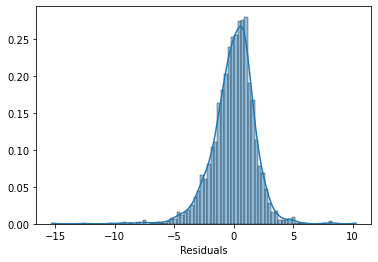

Plotting residuals for GRS__grasby_2020__mean_entorhinal_surfavg in PPMI


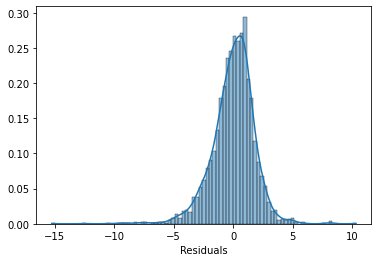

Plotting residuals for GRS__grasby_2020__mean_paracentral_surfavg in PPMI


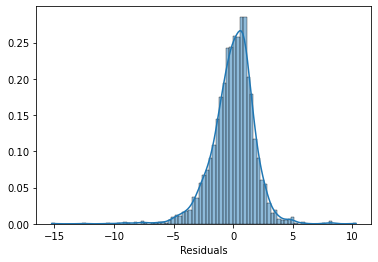

Plotting residuals for GRS__grasby_2020__mean_lateraloccipital_thickavg in PPMI


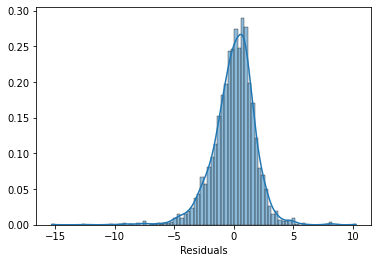

Plotting residuals for GRS__adams_2016__intracranial_volume in PPMI


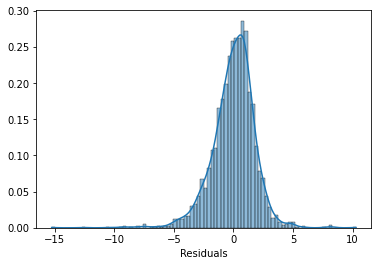

Plotting residuals for GRS__grasby_2020__mean_parahippocampal_thickavg in PPMI


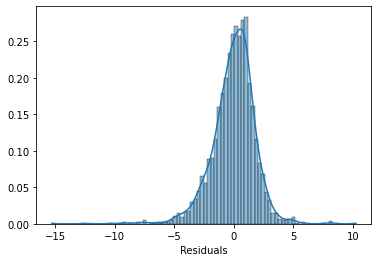

Plotting residuals for GRS__davies_2016__memory_performance in PPMI


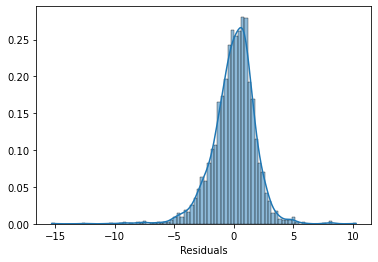

Plotting residuals for GRS__savage_2018__intelligence in PPMI


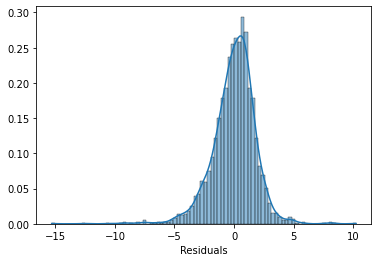

Plotting residuals for GRS__satizabal_2019__subcortical_volume_accumbens in PPMI


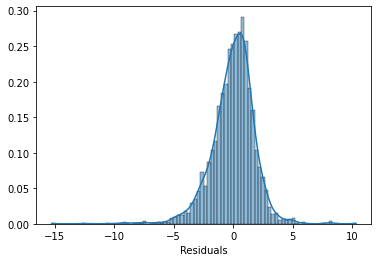

Plotting residuals for GRS__howard_2019__depression in PPMI


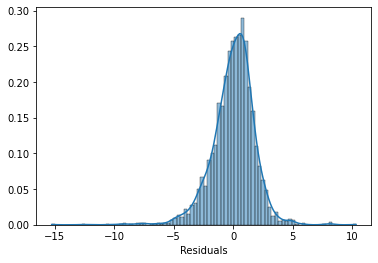

Plotting residuals for GRS__sargurupremraj_2020__white_matter_hyperintensities in PPMI


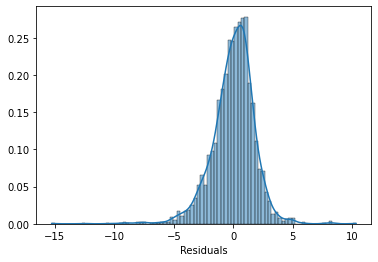

Analysing PDBP (1819, 15) ...
                         Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          Cognitive score
No. Observations:          1819             Method:                      REML           
No. Groups:                782              Scale:                       4.0171         
Min. group size:           1                Log-Likelihood:              -4434.0449     
Max. group size:           6                Converged:                   Yes            
Mean group size:           2.3                                                          
----------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                   29.726    0.997  29.820 0.000  27.772 31.680
Age at PD diagnos

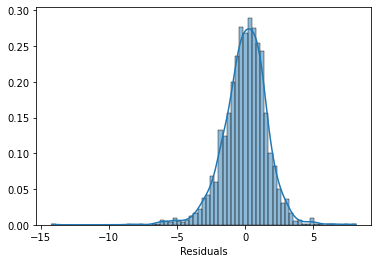

Plotting residuals for GRS__lee_2018__educational_attainment in PDBP


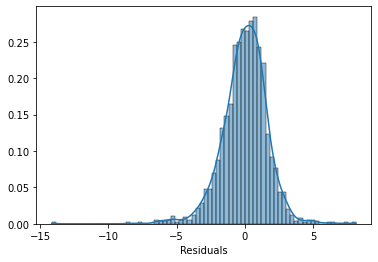

Plotting residuals for GRS__davies_2016__reasoning in PDBP


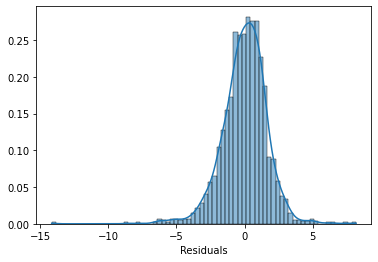

Plotting residuals for GRS__lee_2018__cognitive_performance in PDBP


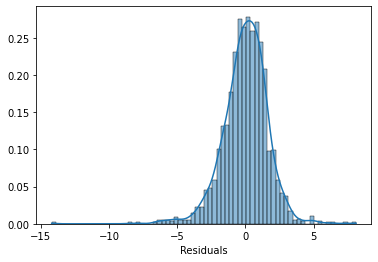

Plotting residuals for GRS__satizabal_2019__subcortical_volume_brainstem in PDBP


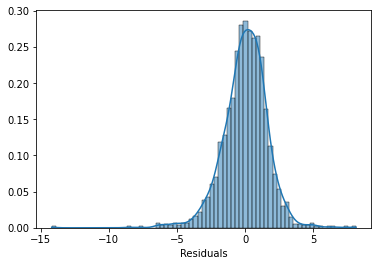

Plotting residuals for GRS__adams_2016__intracranial_volume in PDBP


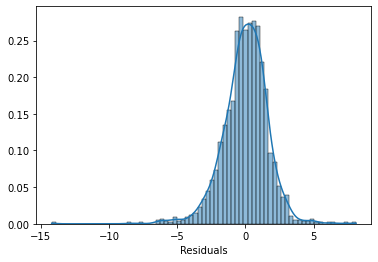

Plotting residuals for GRS__savage_2018__intelligence in PDBP


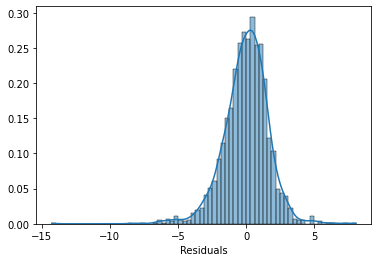

Plotting residuals for GRS__neale_lab_2018__trouble_falling_asleep in PDBP


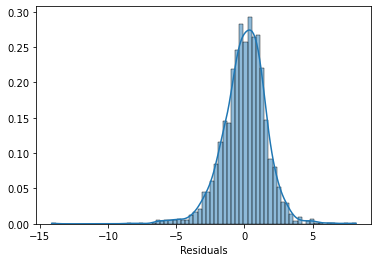

Plotting residuals for GRS__grasby_2020__mean_lateralorbitofrontal_surfavg in PDBP


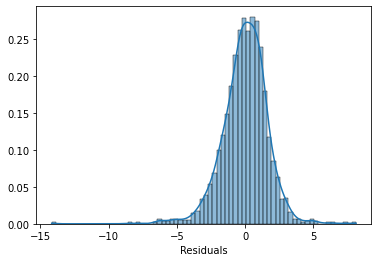

HBS is missing essential clinical or genetic data, N = 0
Analysing LCC without severe GBA muts (137, 15) ...
                         Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         Cognitive score
No. Observations:           137             Method:                     REML           
No. Groups:                 50              Scale:                      6.1840         
Min. group size:            1               Log-Likelihood:             -344.9560      
Max. group size:            4               Converged:                  Yes            
Mean group size:            2.7                                                        
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                           

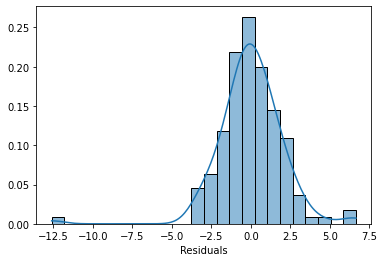

Plotting residuals for GRS__grasby_2020__mean_full_surfarea in LCC


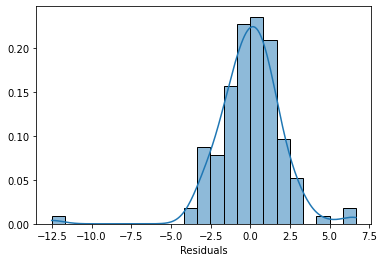

Plotting residuals for GRS__savage_2018__intelligence in LCC


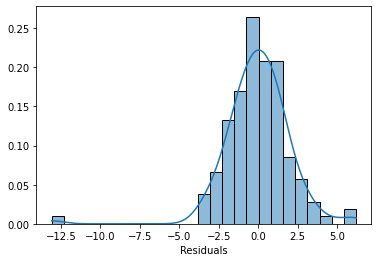

Plotting residuals for GRS__grasby_2020__mean_isthmuscingulate_thickavg in LCC


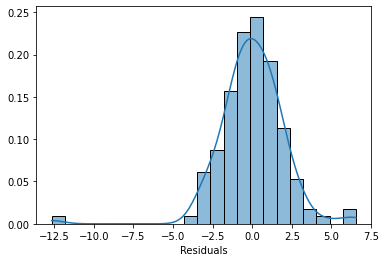

Plotting residuals for GRS__satizabal_2019__subcortical_volume_accumbens in LCC


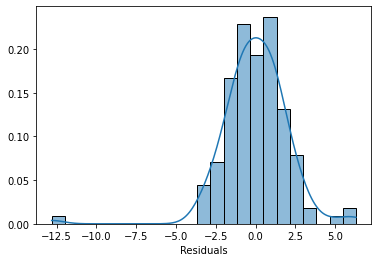

Plotting residuals for GRS__grasby_2020__mean_inferiorparietal_thickavg in LCC


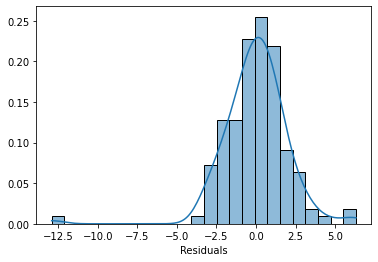

Steady is missing essential clinical or genetic data, N = 0
Analysing Sure (859, 15) ...
                        Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Cognitive score
No. Observations:          859             Method:                     REML           
No. Groups:                240             Scale:                      1.6415         
Min. group size:           1               Log-Likelihood:             -1639.8533     
Max. group size:           4               Converged:                  Yes            
Mean group size:           3.6                                                        
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                   28.788    0.904 31.837

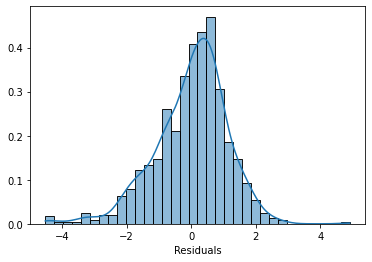

Plotting residuals for GRS__grasby_2020__mean_full_surfarea in Sure


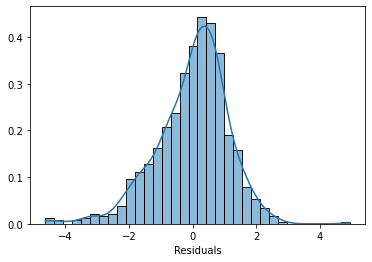

Plotting residuals for GRS__grasby_2020__mean_lingual_thickavg in Sure


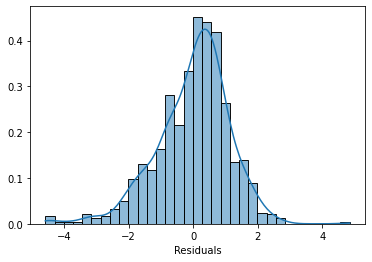

Plotting residuals for GRS__grasby_2020__mean_parstriangularis_thickavg in Sure


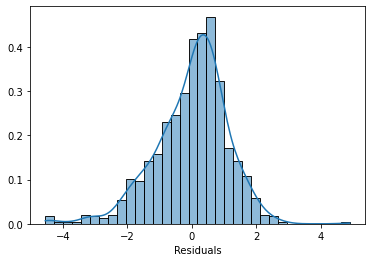

Plotting residuals for GRS__savage_2018__intelligence in Sure


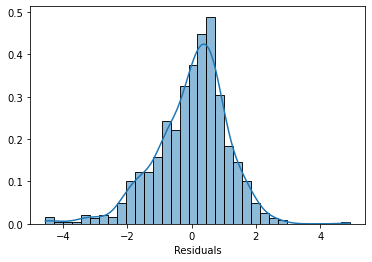

Plotting residuals for GRS__grasby_2020__mean_superiorparietal_surfavg in Sure


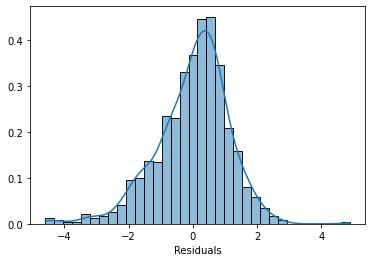

BioFIND does not have longitudinal data


In [121]:
cohorts = ["PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:

    #Read in MOCA data (long format)
    moca = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/moca_allparticipants.tab',
                       delimiter = "\t")

    #Read in demographics data to get age at baseline - this is just PD cases
    demo = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_sex.tab',
                      delimiter = "\t")
    
    #Read in education level data
    edu = pd.read_csv('/home/jupyter/clinical_data_v2-5/edu_allparticipants.tab',
                 delimiter = "\t")


    #Read in age at diagnosis data
    age_dx = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab',
                        delimiter = "\t")

    #Read in PRS
    PRS = pd.read_csv(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab',
                         delimiter = "\t", index_col = 0)

    #Read in genetic PCs
    PCs = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/{cohort}.pca.eigenvec',
                     delimiter = "\t")
    #Rename FID column as it is reading in as #FID
    PCs.rename(columns = {'#FID':'FID'}, inplace = True)

    #Read in APOE data
    APOE = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/APOE.raw',
                      delimiter = " ")
    
    ### Severe GBA mutations ###
    
    #Read in severe GBA mutations 
    GBA_severe = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/severe_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_severe = GBA_severe.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of severe GBA mutations
    GBA_severe['Number of severe GBA mutations'] = GBA_severe.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_severe_select = GBA_severe.copy()
    GBA_severe_select = GBA_severe_select.loc[:, ['FID', 'IID', 'Number of severe GBA mutations']]
    
    ### Mild GBA mutations ###
    
    #Read in mild GBA mutations 
    GBA_mild = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/mild_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_mild = GBA_mild.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of mild GBA mutations
    GBA_mild['Number of mild GBA mutations'] = GBA_mild.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_mild_select = GBA_mild.copy()
    GBA_mild_select = GBA_mild_select.loc[:, ['FID', 'IID', 'Number of mild GBA mutations']]
    
    ### Undetermined GBA mutations
    
    #Read in unknown GBA mutations 
    GBA_undetermined = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_undetermined = GBA_undetermined.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of undetermined GBA mutations
    GBA_undetermined['Number of undetermined GBA mutations'] = GBA_undetermined.iloc[:, 2:75].sum(axis = 1)
    GBA_undetermined[GBA_undetermined['Number of undetermined GBA mutations'] > 0]
    
    #Select just total number of mutations column
    GBA_undetermined_select = GBA_undetermined.copy()
    GBA_undetermined_select = GBA_undetermined_select.loc[:, ['FID', 'IID', 'Number of undetermined GBA mutations']]
    
    
    #Merge moca with demographic data, age at diagnosis data, PRS, APOE and GBA data
    merged1 = moca.merge(demo, left_on = 'participant_id', right_on = 'FID', how = 'inner')
    
    #Make list of dataframes to merge
    data_frames = [merged1, age_dx, edu, PCs, APOE, GBA_severe_select, GBA_mild_select, GBA_undetermined_select]
    
    #Merge all the rest of the dataframes by FID and IID
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['FID', 'IID'],
                                            how='inner'), data_frames)
    
    #Sort by ID and visit month
    df_merged = df_merged.sort_values(by = ['participant_id', 'visit_month'])

    #Calculate years from PD diagnosis to each visit
    df_merged['YEARS_DIAGNOSIS_TO_BL'] = df_merged.age_at_baseline - df_merged.age_at_diagnosis
    df_merged['YEARS_FROM_DIAGNOSIS'] = df_merged.YEARS_DIAGNOSIS_TO_BL + df_merged.visit_month/12

    #Map education level as dummy variable
    df_merged_edu = df_merged.copy()
    
    df_merged_edu['education_dummy'] = df_merged_edu['education_level_years'].replace({
        'Unknown':np.nan,
        '0 years':0,
        'Less than 12 years':1,
        '12-16 years':2,
        'Greater than 16 years':3
    })
    
    #Convert the education dummy variable as categorical
    df_merged_edu['education_dummy'] = df_merged_edu['education_dummy'].astype("category")
    
    #Select relevant columns
    merged_final = df_merged_edu.copy()

    merged_final = merged_final.loc[:, ['participant_id',
                                        'YEARS_FROM_DIAGNOSIS',
                                        'moca_total_score',
                                        'sex',
                                        'education_dummy',
                                        'age_at_diagnosis',
                                        'PC1', 'PC2', 'PC3','PC4',
                                        '19:44908684:T:C_C',
                                        '19:44908822:C:T_T',
                                        'Number of severe GBA mutations', 
                                        'Number of mild GBA mutations',
                                        'Number of undetermined GBA mutations']]
    
    
    #Rename columns
    merged_final.rename(columns = {'participant_id':'Patient ID',
                                   'YEARS_FROM_DIAGNOSIS':'Time since PD onset',
                                      'education_dummy':'Education level',
                                      'moca_total_score':'Cognitive score',
                                      'age_at_diagnosis':'Age at PD diagnosis',
                                      'sex':'Sex',
                                      '19:44908684:T:C_C':'rs429358',
                                      '19:44908822:C:T_T':'rs7412'}, inplace = True)


    #Remove rows missing any data
    merged_final_nomiss = merged_final.copy()
    merged_final_nomiss = merged_final_nomiss.dropna()
    
    #If the number of rows is equal to the number of participants (age_dx)
    #This means there is only one observation per participant
    if len(merged_final_nomiss) == 0:
        
        print(f'{cohort} is missing essential clinical or genetic data, N = 0')
        
    elif len(df_merged) == len(PCs):
        
        print(f'{cohort} does not have longitudinal data')
    
    #There can be errors if there are no patients that carry severe GBA mutations (all 0), like in LCC
    #In this case, drop just that column from the analysis
    #Using altered analysis function without severe GBA mutations column
    elif merged_final_nomiss['Number of severe GBA mutations'].nunique() == 1:
        
        print(f'Analysing {cohort} without severe GBA muts', merged_final_nomiss.shape, '...')

        merged_final_nomiss_noGBA = merged_final_nomiss.copy()
        
        #Remove severe GBA mutations column
        merged_final_nomiss_noGBA = merged_final_nomiss_noGBA.drop(columns=['Number of severe GBA mutations'])
        
        #Join with PRS data
        merged_PRS = merged_final_nomiss_noGBA.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis - the function returns both a df of results and the residuals, so need two arguments
        df_results,residuals = run_statistical_analyses_updated_noGBA(merged_PRS)
        
        with open(f'/home/jupyter/Johann_PRS/{cohort}_MoCA_results_updated.tab', 'w') as f:
            f.write(df_results.to_csv(index=True, sep='\t'))
            
        #Plot residuals for just GRSs that are significant (p < 0.05)
        significant_GRS = df_results[df_results['p-value'] < 0.05]
        
        significant_GRS_new = significant_GRS.copy()
        #Reset index so that the GRS name is a column
        significant_GRS_new = significant_GRS_new.reset_index()
        
        #Loop over significant GRSs and plot residuals
        for i in range(len(significant_GRS_new)):
            print(f'Plotting residuals for', significant_GRS_new.loc[i, "index"], 'in', cohort)
            GRS = significant_GRS_new.loc[i, "index"]
            plot_residuals(residuals, GRS)
            plt.savefig(f'/home/jupyter/Johann_PRS/residuals/{cohort}_{GRS}_MoCA_residuals.png') #savefig must come before plt.show
            plt.show()
        
        
    else:
        print(f'Analysing {cohort}', merged_final_nomiss.shape, '...')

        #Join with PRS data
        merged_PRS = merged_final_nomiss.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis - the function returns both a df of results and the residuals, so need two arguments
        df_results,residuals = run_statistical_analyses_updated(merged_PRS)
        
        with open(f'/home/jupyter/Johann_PRS/{cohort}_MoCA_results_updated.tab', 'w') as f:
            f.write(df_results.to_csv(index=True, sep='\t'))
        
        #Plot residuals for just GRSs that are significant (p < 0.05)
        significant_GRS = df_results[df_results['p-value'] < 0.05]
        
        significant_GRS_new = significant_GRS.copy()
        #Reset index so that the GRS name is a column
        significant_GRS_new = significant_GRS_new.reset_index()
        
        #Loop over significant GRSs and plot residuals
        for i in range(len(significant_GRS_new)):
            print(f'Plotting residuals for', significant_GRS_new.loc[i, "index"], 'in', cohort)
            GRS = significant_GRS_new.loc[i, "index"]
            plot_residuals(residuals, GRS)
            plt.savefig(f'/home/jupyter/Johann_PRS/residuals/{cohort}_{GRS}_MoCA_residuals.png') #savefig must come before plt.show
            plt.show()
        


In [122]:
%%bash
ls /home/jupyter/Johann_PRS/residuals

LCC_GRS__grasby_2020__mean_full_surfarea_MoCA_residuals.png
LCC_GRS__grasby_2020__mean_inferiorparietal_thickavg_MoCA_residuals.png
LCC_GRS__grasby_2020__mean_isthmuscingulate_thickavg_MoCA_residuals.png
LCC_GRS__grasby_2020__mean_rostralmiddlefrontal_surfavg_MoCA_residuals.png
LCC_GRS__satizabal_2019__subcortical_volume_accumbens_MoCA_residuals.png
LCC_GRS__savage_2018__intelligence_MoCA_residuals.png
PDBP_GRS__adams_2016__intracranial_volume_MoCA_residuals.png
PDBP_GRS__davies_2016__reasoning_MoCA_residuals.png
PDBP_GRS__grasby_2020__mean_lateralorbitofrontal_surfavg_MoCA_residuals.png
PDBP_GRS__grasby_2020__mean_supramarginal_thickavg_MoCA_residuals.png
PDBP_GRS__lee_2018__cognitive_performance_MoCA_residuals.png
PDBP_GRS__lee_2018__educational_attainment_MoCA_residuals.png
PDBP_GRS__neale_lab_2018__trouble_falling_asleep_MoCA_residuals.png
PDBP_GRS__satizabal_2019__subcortical_volume_brainstem_MoCA_residuals.png
PDBP_GRS__savage_2018__intelligence_MoCA_residuals.png
PPMI_GRS__adams

There are issues with BioFIND I think because there is only one observation per patient and not longitudinal data.

### Export results to workspace bucket

In [123]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/*_MoCA_results_updated.tab {WORKSPACE_BUCKET}')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/*_MoCA_results_updated.tab gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181
Copying file:///home/jupyter/Johann_PRS/LCC_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/PDBP_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/PPMI_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/Sure_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
- [4 files][ 48.6 KiB/ 48.6 KiB]                                                
Operation completed over 4 objects/48.6 KiB.                                     


In [124]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/residuals/* {WORKSPACE_BUCKET}/residuals')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/residuals/* gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/residuals
Copying file:///home/jupyter/Johann_PRS/residuals/LCC_GRS__grasby_2020__mean_full_surfarea_MoCA_residuals.png [Content-Type=image/png]...
Copying file:///home/jupyter/Johann_PRS/residuals/LCC_GRS__grasby_2020__mean_inferiorparietal_thickavg_MoCA_residuals.png [Content-Type=image/png]...
Copying file:///home/jupyter/Johann_PRS/residuals/LCC_GRS__grasby_2020__mean_isthmuscingulate_thickavg_MoCA_residuals.png [Content-Type=image/png]...
Copying file:///home/jupyter/Johann_PRS/residuals/LCC_GRS__grasby_2020__mean_rostralmiddlefrontal_surfavg_MoCA_residuals.png [Content-Type=image/png]...
/ [4 files][ 45.2 KiB/ 45.2 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for furth

## Additional analyses

The reviewers have asked for two additional analyses in particular:

* Adding interactions terms between (i) the PRS variable and (ii) each APOE and GBA variable.
* Running the analyses without the APOE and GBA variables as covariates.
* Checking if the combined model is significantly better than each individual model
* Computing the correlations between the four significant PRS

## Interaction terms

In [70]:
%%bash
#Make directory to save interaction results
mkdir /home/jupyter/Johann_PRS/interactions

In [10]:
def run_statistical_analyses_with_interaction_terms(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores

    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value

    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Define APOE and GBA variable names
    apoe_gba_columns = [
        'Number of severe GBA mutations',
        'Number of mild GBA mutations',
        'Number of undetermined GBA mutations',
        'rs429358',
        'rs7412'
    ]
    interactions_columns = [f'Interaction {i}' for i in range(1, len(apoe_gba_columns) + 1)]
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:
        
        # Add interaction terms
        df_copy[interactions_columns] = (
            df_copy[apoe_gba_columns].mul(df_copy[col], axis=0)
        )

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358', 'rs7412'] +
            ['Number of severe GBA mutations', 'Number of mild GBA mutations',
             'Number of undetermined GBA mutations'] +
            interactions_columns +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000)

        df_temp = pd.DataFrame(pd.concat([
            model.params[[col] + interactions_columns],
            model.conf_int().loc[[col] + interactions_columns, 0],
            model.conf_int().loc[[col] + interactions_columns, 1],
            model.pvalues[[col] + interactions_columns]
        ])).T
        df_temp.columns = pd.MultiIndex.from_product((
            ['Effect size', 'Lower bound (95%-CI)', 'Upper bound (95%-CI)', 'p-value'],
            ['GRS'] + interactions_columns
        ))
        df_res.append(df_temp)
        
        print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.concat(df_res, axis=0)
    df_res.index = grs_col
    
    return df_res

In [11]:
def run_statistical_analyses_with_interaction_terms_noGBA(df):
    """Run the statistical analyses WITHOUT SEVERE GBA MUTATIONS.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores

    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value

    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Define APOE and GBA variable names
    apoe_gba_columns = [
        'Number of mild GBA mutations',
        'Number of undetermined GBA mutations',
        'rs429358',
        'rs7412'
    ]
    interactions_columns = [f'Interaction {i}' for i in range(1, len(apoe_gba_columns) + 1)]
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:
        
        # Add interaction terms
        df_copy[interactions_columns] = (
            df_copy[apoe_gba_columns].mul(df_copy[col], axis=0)
        )

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358', 'rs7412'] +
            ['Number of mild GBA mutations',
             'Number of undetermined GBA mutations'] +
            interactions_columns +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000)

        df_temp = pd.DataFrame(pd.concat([
            model.params[[col] + interactions_columns],
            model.conf_int().loc[[col] + interactions_columns, 0],
            model.conf_int().loc[[col] + interactions_columns, 1],
            model.pvalues[[col] + interactions_columns]
        ])).T
        df_temp.columns = pd.MultiIndex.from_product((
            ['Effect size', 'Lower bound (95%-CI)', 'Upper bound (95%-CI)', 'p-value'],
            ['GRS'] + interactions_columns
        ))
        df_res.append(df_temp)
        
        print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.concat(df_res, axis=0)
    df_res.index = grs_col
    
    return df_res

In [24]:
cohorts = ["PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:

    #Read in MOCA data (long format)
    moca = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/moca_allparticipants.tab',
                       delimiter = "\t")

    #Read in demographics data to get age at baseline - this is just PD cases
    demo = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_sex.tab',
                      delimiter = "\t")
    
    #Read in education level data
    edu = pd.read_csv('/home/jupyter/clinical_data_v2-5/edu_allparticipants.tab',
                 delimiter = "\t")


    #Read in age at diagnosis data
    age_dx = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab',
                        delimiter = "\t")

    #Read in PRS
    PRS = pd.read_csv(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab',
                         delimiter = "\t", index_col = 0)

    #Read in genetic PCs
    PCs = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/{cohort}.pca.eigenvec',
                     delimiter = "\t")
    #Rename FID column as it is reading in as #FID
    PCs.rename(columns = {'#FID':'FID'}, inplace = True)

    #Read in APOE data
    APOE = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/APOE.raw',
                      delimiter = " ")
    
    ### Severe GBA mutations ###
    
    #Read in severe GBA mutations 
    GBA_severe = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/severe_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_severe = GBA_severe.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of severe GBA mutations
    GBA_severe['Number of severe GBA mutations'] = GBA_severe.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_severe_select = GBA_severe.copy()
    GBA_severe_select = GBA_severe_select.loc[:, ['FID', 'IID', 'Number of severe GBA mutations']]
    
    ### Mild GBA mutations ###
    
    #Read in mild GBA mutations 
    GBA_mild = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/mild_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_mild = GBA_mild.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of mild GBA mutations
    GBA_mild['Number of mild GBA mutations'] = GBA_mild.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_mild_select = GBA_mild.copy()
    GBA_mild_select = GBA_mild_select.loc[:, ['FID', 'IID', 'Number of mild GBA mutations']]
    
    ### Undetermined GBA mutations
    
    #Read in unknown GBA mutations 
    GBA_undetermined = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_undetermined = GBA_undetermined.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of undetermined GBA mutations
    GBA_undetermined['Number of undetermined GBA mutations'] = GBA_undetermined.iloc[:, 2:75].sum(axis = 1)
    GBA_undetermined[GBA_undetermined['Number of undetermined GBA mutations'] > 0]
    
    #Select just total number of mutations column
    GBA_undetermined_select = GBA_undetermined.copy()
    GBA_undetermined_select = GBA_undetermined_select.loc[:, ['FID', 'IID', 'Number of undetermined GBA mutations']]
    
    
    #Merge moca with demographic data, age at diagnosis data, PRS, APOE and GBA data
    merged1 = moca.merge(demo, left_on = 'participant_id', right_on = 'FID', how = 'inner')
    
    #Make list of dataframes to merge
    data_frames = [merged1, age_dx, edu, PCs, APOE, GBA_severe_select, GBA_mild_select, GBA_undetermined_select]
    
    #Merge all the rest of the dataframes by FID and IID
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['FID', 'IID'],
                                            how='inner'), data_frames)
    
    #Sort by ID and visit month
    df_merged = df_merged.sort_values(by = ['participant_id', 'visit_month'])

    #Calculate years from PD diagnosis to each visit
    df_merged['YEARS_DIAGNOSIS_TO_BL'] = df_merged.age_at_baseline - df_merged.age_at_diagnosis
    df_merged['YEARS_FROM_DIAGNOSIS'] = df_merged.YEARS_DIAGNOSIS_TO_BL + df_merged.visit_month/12

    #Map education level as dummy variable
    df_merged_edu = df_merged.copy()
    
    df_merged_edu['education_dummy'] = df_merged_edu['education_level_years'].replace({
        'Unknown':np.nan,
        '0 years':0,
        'Less than 12 years':1,
        '12-16 years':2,
        'Greater than 16 years':3
    })
    
    #Convert the education dummy variable as categorical
    df_merged_edu['education_dummy'] = df_merged_edu['education_dummy'].astype("category")
    
    #Select relevant columns
    merged_final = df_merged_edu.copy()

    merged_final = merged_final.loc[:, ['participant_id',
                                        'YEARS_FROM_DIAGNOSIS',
                                        'moca_total_score',
                                        'sex',
                                        'education_dummy',
                                        'age_at_diagnosis',
                                        'PC1', 'PC2', 'PC3','PC4',
                                        '19:44908684:T:C_C',
                                        '19:44908822:C:T_T',
                                        'Number of severe GBA mutations', 
                                        'Number of mild GBA mutations',
                                        'Number of undetermined GBA mutations']]
    
    
    #Rename columns
    merged_final.rename(columns = {'participant_id':'Patient ID',
                                   'YEARS_FROM_DIAGNOSIS':'Time since PD onset',
                                      'education_dummy':'Education level',
                                      'moca_total_score':'Cognitive score',
                                      'age_at_diagnosis':'Age at PD diagnosis',
                                      'sex':'Sex',
                                      '19:44908684:T:C_C':'rs429358',
                                      '19:44908822:C:T_T':'rs7412'}, inplace = True)


    #Remove rows missing any data
    merged_final_nomiss = merged_final.copy()
    merged_final_nomiss = merged_final_nomiss.dropna()
    
    #If the number of rows is equal to the number of participants (age_dx)
    #This means there is only one observation per participant
    if len(merged_final_nomiss) == 0:
        
        print(f'{cohort} is missing essential clinical or genetic data, N = 0')
        
    elif len(df_merged) == len(PCs):
        
        print(f'{cohort} does not have longitudinal data')
    
    #There can be errors if there are no patients that carry severe GBA mutations (all 0), like in LCC
    #Also if there are too few individuals that have at least 1 severe GBA mutation - this causes problems for the interaction terms
    #In this case, drop just that column from the analysis
    #Using altered analysis function without severe GBA mutations column
    elif merged_final_nomiss['Number of severe GBA mutations'].std() < 0.1:
        
        print(f'Analysing {cohort} without severe GBA muts', merged_final_nomiss.shape, '...')

        merged_final_nomiss_noGBA = merged_final_nomiss.copy()
        
        #Remove severe GBA mutations column
        merged_final_nomiss_noGBA = merged_final_nomiss_noGBA.drop(columns=['Number of severe GBA mutations'])
        
        #Join with PRS data
        merged_PRS = merged_final_nomiss_noGBA.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis
        df_results = run_statistical_analyses_with_interaction_terms_noGBA(merged_PRS)
        
        with open(f'/home/jupyter/Johann_PRS/interactions/{cohort}_MoCA_results_updated.tab', 'w') as f:
            f.write(df_results.to_csv(index=True, sep='\t'))
            
        
    else:
        print(f'Analysing {cohort}', merged_final_nomiss.shape, '...')

        #Join with PRS data
        merged_PRS = merged_final_nomiss.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis
        df_results = run_statistical_analyses_with_interaction_terms(merged_PRS)
        
        with open(f'/home/jupyter/Johann_PRS/interactions/{cohort}_MoCA_results_updated.tab', 'w') as f:
            f.write(df_results.to_csv(index=True, sep='\t'))
    

Analysing PPMI without severe GBA muts (2755, 15) ...
                        Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Cognitive score
No. Observations:          2755            Method:                     REML           
No. Groups:                465             Scale:                      3.7931         
Min. group size:           1               Log-Likelihood:             -6208.1544     
Max. group size:           10              Converged:                  Yes            
Mean group size:           5.9                                                        
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                   31.162    0.965 32.293 0.000 29.271 33.053
Age at PD diag

### Export results to workspace bucket

In [25]:
%%bash
ls /home/jupyter/Johann_PRS/interactions

LCC_MoCA_results_updated.tab
PDBP_MoCA_results_updated.tab
PPMI_MoCA_results_updated.tab
Sure_MoCA_results_updated.tab


In [26]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/interactions/* {WORKSPACE_BUCKET}/interactions/')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/interactions/* gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/interactions/
Copying file:///home/jupyter/Johann_PRS/interactions/LCC_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/interactions/PDBP_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/interactions/PPMI_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/interactions/Sure_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
- [4 files][173.8 KiB/173.8 KiB]                                                
Operation completed over 4 objects/173.8 KiB.                                    


### Troubleshooting

Getting errors in PPMI (and probably other cohorts) LinAlgError: Singular matrix. Probably because the dataset is too small for the number of variables in the model (all the interaction terms) and high collinearity between the variables. There are no missing values.

In [13]:
cohort

'PPMI'

In [18]:
#Check value counts for severe GBA mutations column
merged_PRS['Number of severe GBA mutations'].value_counts()

0    2753
1       2
Name: Number of severe GBA mutations, dtype: int64

In [19]:
#Check standard deviation for severe GBA mutations column
merged_PRS['Number of severe GBA mutations'].std()

0.026938619371515288

In [21]:
cohort
#Sure cohort is also running into errors after filter of std > 0.05

'Sure'

In [22]:
#Check value counts for severe GBA mutations column
merged_PRS['Number of severe GBA mutations'].value_counts()

0    855
1      4
Name: Number of severe GBA mutations, dtype: int64

In [23]:
#Check standard deviation for severe GBA mutations column
merged_PRS['Number of severe GBA mutations'].std()

0.06811971576852144

In [14]:
np.linalg.svd(merged_PRS, 0)

UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [15]:
merged_PRS.isnull().sum()

Patient ID                                                 0
Time since PD onset                                        0
Cognitive score                                            0
Sex                                                        0
Education level                                            0
                                                          ..
GRS__howard_2019__depression                               0
GRS__sargurupremraj_2020__white_matter_hyperintensities    0
GRS__grasby_2020__mean_frontalpole_thickavg                0
GRS__grasby_2020__mean_medialorbitofrontal_surfavg         0
GRS__grasby_2020__mean_precuneus_thickavg                  0
Length: 115, dtype: int64

In [16]:
# Check for missing values in each column
missing_values = merged_PRS.isnull().sum()

# Filter for variables with missing values
variables_with_missing_values = missing_values[missing_values > 0]

# Print the variables with missing values
print(variables_with_missing_values)

Series([], dtype: int64)


In [80]:
xtxy = np.dot(df_copy[exog].T, df_copy['Cognitive score'])
xtxy

array([ 7.33440000e+04,  4.44392400e+06,  9.88850000e+04,  2.68269583e+05,
        1.66516000e+05,  1.02842072e+02, -7.68333169e+01,  8.76401060e+00,
        3.47743201e+01,  1.84740000e+04,  1.21780000e+04,  5.00000000e+01,
        7.78400000e+03,  4.41088000e+05,  2.89578060e+02])

In [81]:
xtxy[:, 0:-1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [82]:
print(df_copy[exog].shape)
print(df_copy['Cognitive score'].shape)

(2755, 15)
(2755,)


In [84]:
xtxy = np.dot(df_copy[exog].values.T, df_copy['Cognitive score'].values)
xtxy

array([ 7.33440000e+04,  4.44392400e+06,  9.88850000e+04,  2.68269583e+05,
        1.66516000e+05,  1.02842072e+02, -7.68333169e+01,  8.76401060e+00,
        3.47743201e+01,  1.84740000e+04,  1.21780000e+04,  5.00000000e+01,
        7.78400000e+03,  4.41088000e+05,  2.89578060e+02])

In [86]:
xtxy = xtxy.reshape(1, -1)  # Reshape xtxy to a 2-dimensional array
fe_params = np.linalg.solve(xtxy[:, 0:-1], xtxy[:, -1])


LinAlgError: Last 2 dimensions of the array must be square

In [87]:
fe_params = np.linalg.solve(xtxy[:-1, :-1], xtxy[:-1, -1])

LinAlgError: Last 2 dimensions of the array must be square

In [88]:
xtxy.shape

(1, 15)

In [91]:
print(xtxy)

[[ 7.33440000e+04  4.44392400e+06  9.88850000e+04  2.68269583e+05
   1.66516000e+05  1.02842072e+02 -7.68333169e+01  8.76401060e+00
   3.47743201e+01  1.84740000e+04  1.21780000e+04  5.00000000e+01
   7.78400000e+03  4.41088000e+05  2.89578060e+02]]


In [92]:
for value in xtxy[0]:
    print(value)

73344.0
4443924.0
98885.0
268269.58333333343
166516.0
102.84207150650002
-76.83331693200006
8.764010603699779
34.77432011799981
18474.0
12178.0
50.0
7784.0
441088.0
289.5780604482957


In [94]:
#Check correlation matrix
corr_matrix = merged_PRS.corr()
print(corr_matrix)

                                                    Time since PD onset  \
Time since PD onset                                            1.000000   
Cognitive score                                               -0.028692   
Sex                                                           -0.008999   
Age at PD diagnosis                                           -0.019524   
PC1                                                            0.037841   
...                                                                 ...   
GRS__howard_2019__depression                                   0.004658   
GRS__sargurupremraj_2020__white_matter_hyperint...            -0.013695   
GRS__grasby_2020__mean_frontalpole_thickavg                    0.029869   
GRS__grasby_2020__mean_medialorbitofrontal_surfavg            -0.014083   
GRS__grasby_2020__mean_precuneus_thickavg                     -0.013457   

                                                    Cognitive score       Sex  \
Time since PD onse

In [96]:
#Calculate Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = merged_PRS.columns
vif["VIF"] = [variance_inflation_factor(merged_PRS.values, i) for i in range(merged_PRS.shape[1])]

print(vif)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [99]:
numeric_df = merged_PRS.select_dtypes(include='number')
numeric_df = numeric_df.dropna()


In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variable"] = numeric_df.columns
vif["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

print(vif)

                                              Variable         VIF
0                                  Time since PD onset    3.294537
1                                      Cognitive score  103.592257
2                                                  Sex   13.121857
3                                  Age at PD diagnosis   72.229123
4                                                  PC1   28.078871
..                                                 ...         ...
108                       GRS__howard_2019__depression  477.144502
109  GRS__sargurupremraj_2020__white_matter_hyperin...    4.745547
110        GRS__grasby_2020__mean_frontalpole_thickavg   26.168892
111  GRS__grasby_2020__mean_medialorbitofrontal_sur...   72.800517
112          GRS__grasby_2020__mean_precuneus_thickavg   15.411284

[113 rows x 2 columns]


## Without APOE and GBA covariates

In [27]:
def run_statistical_analyses_without_apoe_and_gba(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores

    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value

    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )
    
    return df_res

In [29]:
%%bash
mkdir /home/jupyter/Johann_PRS/noAPOE_GBA/

In [30]:
cohorts = ["PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:

    #Read in MOCA data (long format)
    moca = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/moca_allparticipants.tab',
                       delimiter = "\t")

    #Read in demographics data to get age at baseline - this is just PD cases
    demo = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_sex.tab',
                      delimiter = "\t")
    
    #Read in education level data
    edu = pd.read_csv('/home/jupyter/clinical_data_v2-5/edu_allparticipants.tab',
                 delimiter = "\t")


    #Read in age at diagnosis data
    age_dx = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab',
                        delimiter = "\t")

    #Read in PRS
    PRS = pd.read_csv(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab',
                         delimiter = "\t", index_col = 0)

    #Read in genetic PCs
    PCs = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/{cohort}.pca.eigenvec',
                     delimiter = "\t")
    #Rename FID column as it is reading in as #FID
    PCs.rename(columns = {'#FID':'FID'}, inplace = True)

    #Read in APOE data
    APOE = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/APOE.raw',
                      delimiter = " ")
    
    ### Severe GBA mutations ###
    
    #Read in severe GBA mutations 
    GBA_severe = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/severe_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_severe = GBA_severe.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of severe GBA mutations
    GBA_severe['Number of severe GBA mutations'] = GBA_severe.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_severe_select = GBA_severe.copy()
    GBA_severe_select = GBA_severe_select.loc[:, ['FID', 'IID', 'Number of severe GBA mutations']]
    
    ### Mild GBA mutations ###
    
    #Read in mild GBA mutations 
    GBA_mild = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/mild_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_mild = GBA_mild.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of mild GBA mutations
    GBA_mild['Number of mild GBA mutations'] = GBA_mild.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_mild_select = GBA_mild.copy()
    GBA_mild_select = GBA_mild_select.loc[:, ['FID', 'IID', 'Number of mild GBA mutations']]
    
    ### Undetermined GBA mutations
    
    #Read in unknown GBA mutations 
    GBA_undetermined = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_undetermined = GBA_undetermined.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of undetermined GBA mutations
    GBA_undetermined['Number of undetermined GBA mutations'] = GBA_undetermined.iloc[:, 2:75].sum(axis = 1)
    GBA_undetermined[GBA_undetermined['Number of undetermined GBA mutations'] > 0]
    
    #Select just total number of mutations column
    GBA_undetermined_select = GBA_undetermined.copy()
    GBA_undetermined_select = GBA_undetermined_select.loc[:, ['FID', 'IID', 'Number of undetermined GBA mutations']]
    
    
    #Merge moca with demographic data, age at diagnosis data, PRS, APOE and GBA data
    merged1 = moca.merge(demo, left_on = 'participant_id', right_on = 'FID', how = 'inner')
    
    #Make list of dataframes to merge
    data_frames = [merged1, age_dx, edu, PCs, APOE, GBA_severe_select, GBA_mild_select, GBA_undetermined_select]
    
    #Merge all the rest of the dataframes by FID and IID
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['FID', 'IID'],
                                            how='inner'), data_frames)
    
    #Sort by ID and visit month
    df_merged = df_merged.sort_values(by = ['participant_id', 'visit_month'])

    #Calculate years from PD diagnosis to each visit
    df_merged['YEARS_DIAGNOSIS_TO_BL'] = df_merged.age_at_baseline - df_merged.age_at_diagnosis
    df_merged['YEARS_FROM_DIAGNOSIS'] = df_merged.YEARS_DIAGNOSIS_TO_BL + df_merged.visit_month/12

    #Map education level as dummy variable
    df_merged_edu = df_merged.copy()
    
    df_merged_edu['education_dummy'] = df_merged_edu['education_level_years'].replace({
        'Unknown':np.nan,
        '0 years':0,
        'Less than 12 years':1,
        '12-16 years':2,
        'Greater than 16 years':3
    })
    
    #Convert the education dummy variable as categorical
    df_merged_edu['education_dummy'] = df_merged_edu['education_dummy'].astype("category")
    
    #Select relevant columns
    merged_final = df_merged_edu.copy()

    merged_final = merged_final.loc[:, ['participant_id',
                                        'YEARS_FROM_DIAGNOSIS',
                                        'moca_total_score',
                                        'sex',
                                        'education_dummy',
                                        'age_at_diagnosis',
                                        'PC1', 'PC2', 'PC3','PC4',
                                        '19:44908684:T:C_C',
                                        '19:44908822:C:T_T',
                                        'Number of severe GBA mutations', 
                                        'Number of mild GBA mutations',
                                        'Number of undetermined GBA mutations']]
    
    
    #Rename columns
    merged_final.rename(columns = {'participant_id':'Patient ID',
                                   'YEARS_FROM_DIAGNOSIS':'Time since PD onset',
                                      'education_dummy':'Education level',
                                      'moca_total_score':'Cognitive score',
                                      'age_at_diagnosis':'Age at PD diagnosis',
                                      'sex':'Sex',
                                      '19:44908684:T:C_C':'rs429358',
                                      '19:44908822:C:T_T':'rs7412'}, inplace = True)


    #Remove rows missing any data
    merged_final_nomiss = merged_final.copy()
    merged_final_nomiss = merged_final_nomiss.dropna()
    
    #If the number of rows is equal to the number of participants (age_dx)
    #This means there is only one observation per participant
    if len(merged_final_nomiss) == 0:
        
        print(f'{cohort} is missing essential clinical or genetic data, N = 0')
        
    elif len(df_merged) == len(PCs):
        
        print(f'{cohort} does not have longitudinal data')
    
        
    else:
        print(f'Analysing {cohort}', merged_final_nomiss.shape, '...')

        #Join with PRS data
        merged_PRS = merged_final_nomiss.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis - the function returns both a df of results and the residuals, so need two arguments
        df_results = run_statistical_analyses_without_apoe_and_gba(merged_PRS)
        
        with open(f'/home/jupyter/Johann_PRS/noAPOE_GBA/{cohort}_MoCA_results_updated.tab', 'w') as f:
            f.write(df_results.to_csv(index=True, sep='\t'))


Analysing PPMI (2755, 15) ...
                        Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Cognitive score
No. Observations:          2755            Method:                     REML           
No. Groups:                465             Scale:                      3.7925         
Min. group size:           1               Log-Likelihood:             -6208.1412     
Max. group size:           10              Converged:                  Yes            
Mean group size:           5.9                                                        
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                   31.191    0.938 33.236 0.000 29.352 33.030
Age at PD diagnosis                   

### Export results to workspace bucket

In [31]:
%%bash
ls /home/jupyter/Johann_PRS/noAPOE_GBA

LCC_MoCA_results_updated.tab
PDBP_MoCA_results_updated.tab
PPMI_MoCA_results_updated.tab
Sure_MoCA_results_updated.tab


In [32]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/noAPOE_GBA/* {WORKSPACE_BUCKET}/noAPOE_GBA/')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/noAPOE_GBA/* gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/noAPOE_GBA/
Copying file:///home/jupyter/Johann_PRS/noAPOE_GBA/LCC_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/noAPOE_GBA/PDBP_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/noAPOE_GBA/PPMI_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/noAPOE_GBA/Sure_MoCA_results_updated.tab [Content-Type=application/octet-stream]...
- [4 files][ 48.6 KiB/ 48.6 KiB]                                                
Operation completed over 4 objects/48.6 KiB.                                     


## Comparing combined PRS vs individual PRS

In [50]:
def compare_combined_prs_vs_individual_prs(df, grs_cols):
    """Likelihood ratio tests."""
    
    # Save the models
    models = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each individual PRS
    for col in grs_cols:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358', 'rs7412'] +
            ['Number of severe GBA mutations', 'Number of mild GBA mutations',
             'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000, reml=False)

        print(model.summary())
        
        # Save the residuals
        models[col] = model

    # Combined PRS
    exog = (
        ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
        [f'PC{i}' for i in range(1, 5)] +
        ['rs429358', 'rs7412'] +
        ['Number of severe GBA mutations', 'Number of mild GBA mutations',
         'Number of undetermined GBA mutations'] +
        grs_cols
    )

    model_combined = sm.MixedLM(
        endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
    )
    model_combined = model_combined.fit(maxiter=2000, reml=False)

    print(model_combined.summary())
    
    model_combined
    
    pvalues = {
        col: 1 - chi2(df=len(grs_cols) - 1).cdf(-2 * (models[col].llf - model_combined.llf))
        for col in grs_cols
    }
    
    return pvalues

In [57]:
def compare_combined_prs_vs_individual_prs_noGBA(df, grs_cols):
    """Likelihood ratio tests."""
    
    # Save the models
    models = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each individual PRS
    for col in grs_cols:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358', 'rs7412'] +
            ['Number of mild GBA mutations',
             'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
        )
        model = model.fit(maxiter=2000, reml=False)

        print(model.summary())
        
        # Save the residuals
        models[col] = model

    # Combined PRS
    exog = (
        ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time since PD onset', 'Education level'] +
        [f'PC{i}' for i in range(1, 5)] +
        ['rs429358', 'rs7412'] +
        ['Number of mild GBA mutations',
         'Number of undetermined GBA mutations'] +
        grs_cols
    )

    model_combined = sm.MixedLM(
        endog=df_copy['Cognitive score'], exog=df_copy[exog], groups=df_copy['Patient ID']
    )
    model_combined = model_combined.fit(maxiter=2000, reml=False)

    print(model_combined.summary())
    
    model_combined
    
    pvalues = {
        col: 1 - chi2(df=len(grs_cols) - 1).cdf(-2 * (models[col].llf - model_combined.llf))
        for col in grs_cols
    }
    
    return pvalues

In [34]:
%%bash
mkdir /home/jupyter/Johann_PRS/combined_PRS/

In [70]:
cohorts = ["PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:

    #Read in MOCA data (long format)
    moca = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/moca_allparticipants.tab',
                       delimiter = "\t")

    #Read in demographics data to get age at baseline - this is just PD cases
    demo = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_sex.tab',
                      delimiter = "\t")
    
    #Read in education level data
    edu = pd.read_csv('/home/jupyter/clinical_data_v2-5/edu_allparticipants.tab',
                 delimiter = "\t")


    #Read in age at diagnosis data
    age_dx = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab',
                        delimiter = "\t")

    #Read in PRS
    PRS = pd.read_csv(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab',
                         delimiter = "\t", index_col = 0)

    #Read in genetic PCs
    PCs = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/{cohort}.pca.eigenvec',
                     delimiter = "\t")
    #Rename FID column as it is reading in as #FID
    PCs.rename(columns = {'#FID':'FID'}, inplace = True)

    #Read in APOE data
    APOE = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/APOE.raw',
                      delimiter = " ")
    
    ### Severe GBA mutations ###
    
    #Read in severe GBA mutations 
    GBA_severe = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/severe_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_severe = GBA_severe.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of severe GBA mutations
    GBA_severe['Number of severe GBA mutations'] = GBA_severe.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_severe_select = GBA_severe.copy()
    GBA_severe_select = GBA_severe_select.loc[:, ['FID', 'IID', 'Number of severe GBA mutations']]
    
    ### Mild GBA mutations ###
    
    #Read in mild GBA mutations 
    GBA_mild = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/mild_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_mild = GBA_mild.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of mild GBA mutations
    GBA_mild['Number of mild GBA mutations'] = GBA_mild.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_mild_select = GBA_mild.copy()
    GBA_mild_select = GBA_mild_select.loc[:, ['FID', 'IID', 'Number of mild GBA mutations']]
    
    ### Undetermined GBA mutations
    
    #Read in unknown GBA mutations 
    GBA_undetermined = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_undetermined = GBA_undetermined.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of undetermined GBA mutations
    GBA_undetermined['Number of undetermined GBA mutations'] = GBA_undetermined.iloc[:, 2:75].sum(axis = 1)
    GBA_undetermined[GBA_undetermined['Number of undetermined GBA mutations'] > 0]
    
    #Select just total number of mutations column
    GBA_undetermined_select = GBA_undetermined.copy()
    GBA_undetermined_select = GBA_undetermined_select.loc[:, ['FID', 'IID', 'Number of undetermined GBA mutations']]
    
    
    #Merge moca with demographic data, age at diagnosis data, PRS, APOE and GBA data
    merged1 = moca.merge(demo, left_on = 'participant_id', right_on = 'FID', how = 'inner')
    
    #Make list of dataframes to merge
    data_frames = [merged1, age_dx, edu, PCs, APOE, GBA_severe_select, GBA_mild_select, GBA_undetermined_select]
    
    #Merge all the rest of the dataframes by FID and IID
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['FID', 'IID'],
                                            how='inner'), data_frames)
    
    #Sort by ID and visit month
    df_merged = df_merged.sort_values(by = ['participant_id', 'visit_month'])

    #Calculate years from PD diagnosis to each visit
    df_merged['YEARS_DIAGNOSIS_TO_BL'] = df_merged.age_at_baseline - df_merged.age_at_diagnosis
    df_merged['YEARS_FROM_DIAGNOSIS'] = df_merged.YEARS_DIAGNOSIS_TO_BL + df_merged.visit_month/12

    #Map education level as dummy variable
    df_merged_edu = df_merged.copy()
    
    df_merged_edu['education_dummy'] = df_merged_edu['education_level_years'].replace({
        'Unknown':np.nan,
        '0 years':0,
        'Less than 12 years':1,
        '12-16 years':2,
        'Greater than 16 years':3
    })
    
    #Convert the education dummy variable as categorical
    df_merged_edu['education_dummy'] = df_merged_edu['education_dummy'].astype("category")
    
    #Select relevant columns
    merged_final = df_merged_edu.copy()

    merged_final = merged_final.loc[:, ['participant_id',
                                        'YEARS_FROM_DIAGNOSIS',
                                        'moca_total_score',
                                        'sex',
                                        'education_dummy',
                                        'age_at_diagnosis',
                                        'PC1', 'PC2', 'PC3','PC4',
                                        '19:44908684:T:C_C',
                                        '19:44908822:C:T_T',
                                        'Number of severe GBA mutations', 
                                        'Number of mild GBA mutations',
                                        'Number of undetermined GBA mutations']]
    
    
    #Rename columns
    merged_final.rename(columns = {'participant_id':'Patient ID',
                                   'YEARS_FROM_DIAGNOSIS':'Time since PD onset',
                                      'education_dummy':'Education level',
                                      'moca_total_score':'Cognitive score',
                                      'age_at_diagnosis':'Age at PD diagnosis',
                                      'sex':'Sex',
                                      '19:44908684:T:C_C':'rs429358',
                                      '19:44908822:C:T_T':'rs7412'}, inplace = True)


    #Remove rows missing any data
    merged_final_nomiss = merged_final.copy()
    merged_final_nomiss = merged_final_nomiss.dropna()
    
    #If the number of rows is equal to the number of participants (age_dx)
    #This means there is only one observation per participant
    if len(merged_final_nomiss) == 0:
        
        print(f'{cohort} is missing essential clinical or genetic data, N = 0')
        
    elif len(df_merged) == len(PCs):
        
        print(f'{cohort} does not have longitudinal data')
        
        
    #There can be errors if there are no patients that carry severe GBA mutations (all 0), like in LCC
    #In this case, drop just that column from the analysis
    #Using altered analysis function without severe GBA mutations column
    elif merged_final_nomiss['Number of severe GBA mutations'].nunique() == 1:
        
        print(f'Analysing {cohort} without severe GBA muts', merged_final_nomiss.shape, '...')

        merged_final_nomiss_noGBA = merged_final_nomiss.copy()
        
        #Remove severe GBA mutations column
        merged_final_nomiss_noGBA = merged_final_nomiss_noGBA.drop(columns=['Number of severe GBA mutations'])
        
        #Join with PRS data
        merged_PRS = merged_final_nomiss_noGBA.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis for the 4 significant PRSs
        pvals = compare_combined_prs_vs_individual_prs_noGBA(merged_PRS, ['GRS__lee_2018__cognitive_performance',
                                                                   'GRS__savage_2018__intelligence',
                                                                   'GRS__lee_2018__educational_attainment',
                                                                   'GRS__davies_2016__reasoning'])
        
        with open(f'/home/jupyter/Johann_PRS/combined_PRS/{cohort}_combined_vs_ind_PRS.csv', 'w', newline="") as csv_file:
            writer = csv.writer(csv_file)
            for key, value in pvals.items():
                writer.writerow([key, value])
        
        #Print correlations
        variables = ['GRS__lee_2018__cognitive_performance',
                          'GRS__savage_2018__intelligence',
                          'GRS__lee_2018__educational_attainment',
                          'GRS__davies_2016__reasoning']
        
        correlation_matrix = merged_PRS[variables].corr()
        
        print(correlation_matrix)
        
        #Save correlation matrix as csv
        correlation_matrix.to_csv(f'/home/jupyter/Johann_PRS/combined_PRS/{cohort}_PRS_corrs.csv', index = True)
        
    else:
        print(f'Analysing {cohort}', merged_final_nomiss.shape, '...')

        #Join with PRS data
        merged_PRS = merged_final_nomiss.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis for the 4 significant PRSs
        pvals = compare_combined_prs_vs_individual_prs(merged_PRS, ['GRS__lee_2018__cognitive_performance',
                                                                   'GRS__savage_2018__intelligence',
                                                                   'GRS__lee_2018__educational_attainment',
                                                                   'GRS__davies_2016__reasoning'])
        
        with open(f'/home/jupyter/Johann_PRS/combined_PRS/{cohort}_combined_vs_ind_PRS.csv', 'w', newline="") as csv_file:
            writer = csv.writer(csv_file)
            for key, value in pvals.items():
                writer.writerow([key, value])
                
         #Print correlations
        variables = ['GRS__lee_2018__cognitive_performance',
                          'GRS__savage_2018__intelligence',
                          'GRS__lee_2018__educational_attainment',
                          'GRS__davies_2016__reasoning']
        
        correlation_matrix = merged_PRS[variables].corr()
        
        print(correlation_matrix)

        #Save correlation matrix as csv
        correlation_matrix.to_csv(f'/home/jupyter/Johann_PRS/combined_PRS/{cohort}_PRS_corrs.csv', index = True)

Analysing PPMI (2755, 15) ...
                     Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Cognitive score
No. Observations:        2755          Method:                   ML             
No. Groups:              465           Scale:                    3.7894         
Min. group size:         1             Log-Likelihood:           -6194.6862     
Max. group size:         10            Converged:                Yes            
Mean group size:         5.9                                                    
--------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                            31.766    0.942  33.718 0.000 29.920 33.613
Age at PD diagnosis                  -0.115    0.011 -10.023 0.000 -0.137 -0.092
Sex                 

### Export results to workspace bucket

In [71]:
%%bash
ls /home/jupyter/Johann_PRS/combined_PRS

LCC_combined_vs_ind_PRS.csv
LCC_PRS_corrs.csv
PDBP_combined_vs_ind_PRS.csv
PDBP_PRS_corrs.csv
PPMI_combined_vs_ind_PRS.csv
PPMI_PRS_corrs.csv
Sure_combined_vs_ind_PRS.csv
Sure_PRS_corrs.csv


In [72]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/combined_PRS/* {WORKSPACE_BUCKET}/combined_PRS/')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/combined_PRS/* gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181/combined_PRS/
Copying file:///home/jupyter/Johann_PRS/combined_PRS/LCC_combined_vs_ind_PRS.csv [Content-Type=text/csv]...
Copying file:///home/jupyter/Johann_PRS/combined_PRS/LCC_PRS_corrs.csv [Content-Type=text/csv]...
Copying file:///home/jupyter/Johann_PRS/combined_PRS/PDBP_combined_vs_ind_PRS.csv [Content-Type=text/csv]...
Copying file:///home/jupyter/Johann_PRS/combined_PRS/PDBP_PRS_corrs.csv [Content-Type=text/csv]...
- [4 files][  1.4 KiB/  1.4 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///home/jupyter/Johann_PRS/combined_PRS/PPMI_combined_vs_ind_PRS.csv [Content-Type=text/csv]...
Cop

## Get MMSE data

Query MMSE data

In [125]:
mmse_query = f"""

SELECT
participant_id, visit_name, visit_month, mms112_total_score
FROM `{BQ_RELEASE_DATASET}.MMSE_corrected_20220506`

"""
mmse = bq_query(mmse_query)

In [ ]:
mmse = mmse.sort_values(by = ['participant_id', 'visit_month'])
#mmse.head()

In [127]:
#Remove duplicated visit entries - rows with #
mmse_nodupli = mmse.copy()
mmse_nodupli = mmse_nodupli[~mmse_nodupli.visit_name.str.contains('#')]

In [128]:
#Check for any other duplicated entries by participant id and visit month
mmse_nodupli[mmse_nodupli.duplicated(['participant_id', 'visit_month'], keep = False)]

Empty DataFrame
Columns: [participant_id, visit_name, visit_month, mms112_total_score]
Index: []

In [129]:
#Write as output
with open('/home/jupyter/clinical_data_v2-5/mmse_allparticipants.tab', 'w') as f:
    f.write(mmse_nodupli.to_csv(index=False, sep='\t'))

In [130]:
#Actually the MMSE has only ever been done at baseline
mmse.visit_month.value_counts()

0.0    1208
Name: visit_month, dtype: int64

## Investigating the statistical association between each PRS and cognitive scores using mixed effects models: MMSE

We are interested in the $\beta$ coefficient associated to each PRS in order to see if it is statistically different from $0$ and, if so, its sign (positive or negative association).

The exogeneous variables are:
* Age at PD diagnosis
* Sex
* Visit number / timestamp of each visit
* Genetic ancestry (first four principal components)
* APOE status: number of alleles for SNPs rs429358 and rs7412 (I used the number of C alleles because they correspond to APOE $\epsilon$4, but it does not matter if you count the other allele).
* GBA status: number of GBA mutations for different categories based on the severity of these mutations: mild, severe, undetermined.

The following function assumes that the columns of the DataFrame have the following names:

* Endogeneous variable: **'Cognitive score'**
* Exogeneous variables: **'Age at PD diagnosis'**, **'Sex'**, **'Visit'**, **'PC1'**, **'PC2'**, **'PC3'**, **'PC4'**
* Other exogeneous variables (APOE and GBA): **rs429358**, **rs7412**, **Number of severe GBA mutations**, **Number of mild GBA mutations**, **Number of undetermined GBA mutations**
* Group variable: **Patient ID**
* Polygenic risk scores: **'GRS__*'** (that is each name must start with **'GRS__'**)

Analyse MMSE vs PRSs

In [123]:
cohorts = ["PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:

    #Read in MMSE data (long format)
    mmse = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/mmse_allparticipants.tab',
                       delimiter = "\t")

    #Read in demographics data to get age at baseline - this is just PD cases
    demo = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_sex.tab',
                      delimiter = "\t")

    #Read in age at diagnosis data
    age_dx = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab',
                        delimiter = "\t")

    #Read in PRS
    PRS = pd.read_csv(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab',
                         delimiter = "\t", index_col = 0)

    #Read in genetic PCs
    PCs = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/{cohort}.pca.eigenvec',
                     delimiter = "\t")
    #Rename FID column as it is reading in as #FID
    PCs.rename(columns = {'#FID':'FID'}, inplace = True)

    #Read in APOE data
    APOE = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/APOE.raw',
                      delimiter = " ")
    
    ### Severe GBA mutations ###
    
    #Read in severe GBA mutations 
    GBA_severe = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/severe_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_severe = GBA_severe.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of severe GBA mutations
    GBA_severe['Number of severe GBA mutations'] = GBA_severe.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_severe_select = GBA_severe.copy()
    GBA_severe_select = GBA_severe_select.loc[:, ['FID', 'IID', 'Number of severe GBA mutations']]
    
    ### Mild GBA mutations ###
    
    #Read in mild GBA mutations 
    GBA_mild = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/mild_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_mild = GBA_mild.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of mild GBA mutations
    GBA_mild['Number of mild GBA mutations'] = GBA_mild.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_mild_select = GBA_mild.copy()
    GBA_mild_select = GBA_mild_select.loc[:, ['FID', 'IID', 'Number of mild GBA mutations']]
    
    ### Undetermined GBA mutations
    
    #Read in unknown GBA mutations 
    GBA_undetermined = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_undetermined = GBA_undetermined.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of undetermined GBA mutations
    GBA_undetermined['Number of undetermined GBA mutations'] = GBA_undetermined.iloc[:, 2:75].sum(axis = 1)
    GBA_undetermined[GBA_undetermined['Number of undetermined GBA mutations'] > 0]
    
    #Select just total number of mutations column
    GBA_undetermined_select = GBA_undetermined.copy()
    GBA_undetermined_select = GBA_undetermined_select.loc[:, ['FID', 'IID', 'Number of undetermined GBA mutations']]
    
    
    #Merge moca with demographic data, age at diagnosis data, PRS, APOE and GBA data
    merged1 = mmse.merge(demo, left_on = 'participant_id', right_on = 'FID', how = 'inner')
    
    #Make list of dataframes to merge
    data_frames = [merged1, age_dx, PCs, APOE, GBA_severe_select, GBA_mild_select, GBA_undetermined_select]
    
    #Merge all the rest of the dataframes by FID and IID
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['FID', 'IID'],
                                            how='inner'), data_frames)
    
    #Sort by ID and visit month
    df_merged = df_merged.sort_values(by = ['participant_id', 'visit_month'])

    #Select relevant columns
    merged_final = df_merged.copy()

    merged_final = merged_final.loc[:, ['participant_id',
                                            'visit_month',
                                           'mms112_total_score',
                                           'sex',
                                           'age_at_diagnosis',
                                           'PC1', 'PC2', 'PC3','PC4',
                                           '19:44908684:T:C_C',
                                           '19:44908822:C:T_T',
                                        'Number of severe GBA mutations', 
                                        'Number of mild GBA mutations',
                                        'Number of undetermined GBA mutations']]

    #Rename columns
    merged_final.rename(columns = {'participant_id':'Patient ID',
                                       'visit_month':'Visit',
                                      'mms112_total_score':'Cognitive score',
                                      'age_at_diagnosis':'Age at PD diagnosis',
                                      'sex':'Sex',
                                      '19:44908684:T:C_C':'rs429358',
                                      '19:44908822:C:T_T':'rs7412'}, inplace = True)


    #Remove rows missing any data
    merged_final_nomiss = merged_final.copy()
    merged_final_nomiss = merged_final_nomiss.dropna()
    
    #If the number of rows is equal to the number of participants (age_dx)
    #This means there is only one observation per participant
    if len(merged_final_nomiss) == 0:
        
        print(f'{cohort} is missing essential clinical or genetic data, N = 0')
        
    elif len(df_merged) <= len(PCs):
        
        print(f'{cohort} does not have longitudinal data')

    else:
        print(f'Analysing {cohort}', merged_final_nomiss.shape, '...')

        #Join with PRS data
        merged_PRS = merged_final_nomiss.merge(PRS, left_on = 'Patient ID', right_index = True, how = 'inner')
        
        #Run analysis
        results = run_statistical_analyses(merged_PRS)
        
        with open(f'/home/jupyter/Johann_PRS/{cohort}_MMSE_results.tab', 'w') as f:
            f.write(results.to_csv(index=True, sep='\t'))

PPMI is missing essential clinical or genetic data, N = 0
PDBP does not have longitudinal data
HBS does not have longitudinal data
LCC is missing essential clinical or genetic data, N = 0
Steady is missing essential clinical or genetic data, N = 0
Sure is missing essential clinical or genetic data, N = 0
BioFIND is missing essential clinical or genetic data, N = 0


## Export results to workspace bucket

In [141]:
%%bash

ls /home/jupyter/Johann_PRS/

BioFIND_PRS_final.tab
HBS_PRS_final.tab
LCC_MoCA_results.tab
LCC_PRS_final.tab
LDpred2_PRS.tab
PDBP_MoCA_results.tab
PDBP_PRS_final.tab
PPMI_MoCA_results.tab
PPMI_PRS_final.tab
Steady_PRS_final.tab
Sure_MoCA_results.tab
Sure_PRS_final.tab


In [142]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/*_MoCA_results.tab {WORKSPACE_BUCKET}')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/*_MoCA_results.tab gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181
Copying file:///home/jupyter/Johann_PRS/LCC_MoCA_results.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/PDBP_MoCA_results.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/PPMI_MoCA_results.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/Sure_MoCA_results.tab [Content-Type=application/octet-stream]...
- [4 files][ 48.6 KiB/ 48.6 KiB]                                                
Operation completed over 4 objects/48.6 KiB.                                     


## Time to cognitive impairment using MoCA cutoff

In [5]:
#Define cutoff in the MoCA to classify cognitive impairment
#Having any cognitive disorder (defined as a MoCA score < 25 based on the paper in Neurology that was mentioned during the meeting) at any time point during follow-up. This is a binary variable (True / False)
moca_cutoff=25

Query MoCA data again (we did this before but can rerun)

In [8]:
moca_query = f"""

SELECT 
*
FROM `{BQ_RELEASE_DATASET}.MOCA`
"""
moca = bq_query(moca_query)

In [8]:
#moca.head()

In [10]:
#Arrange by participant ID and visit month and select relevant columns
moca = moca.sort_values(by = ['participant_id', 'visit_month'])
moca = moca.loc[:, ['participant_id', 'visit_name', 'visit_month', 'moca_total_score']]

In [11]:
#Remove duplicated visit entries - rows with #
moca_nodupli = moca.copy()
moca_nodupli = moca_nodupli[~moca_nodupli.visit_name.str.contains('#')]

In [9]:
#moca_nodupli.head()

In [10]:
#Check for any other duplicated entries by participant id and visit month
#moca_nodupli[moca_nodupli.duplicated(['participant_id', 'visit_month'], keep = False)]

In [14]:
#There are still a few individuals with duplicated entries by participant_id and visit_month with different MoCA scores
#Just keep the first datapoint
moca_nodupli_final = moca_nodupli.copy()
moca_nodupli_final = moca_nodupli_final.drop_duplicates(subset = ['participant_id', 'visit_month'], keep = 'first')

In [15]:
#Read in age at diagnosis and demographics data
demo = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_sex.tab',
                    delimiter = "\t")

aao = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab',
                   delimiter = "\t").loc[:, ['FID', 'IID', 'age_at_diagnosis']]

In [25]:
#Merge with demographics and age at diagnosis data to get time from diagnosis
temp = moca_nodupli_final.merge(demo, left_on = 'participant_id', right_on = 'IID')
merged = temp.merge(aao, on = (['FID', 'IID']))

In [11]:
#merged.head()

In [27]:
#Check whether there are any individuals with multiple entires for visit_name and visit_month
#Because we merged on participant_id + visit_name + visit_month, there may be some individuals with the same visit name but different visit months
merged[merged.duplicated(['participant_id', 'visit_name'])]

Empty DataFrame
Columns: [participant_id, visit_name, visit_month, moca_total_score, FID, IID, sex, age_at_baseline, age_at_diagnosis]
Index: []

In [28]:
#Calculate time from diagnosis for each visit
merged['YEARS_DIAGNOSIS_TO_BL'] = merged.age_at_baseline - merged.age_at_diagnosis
merged['YEARS_FROM_DIAGNOSIS'] = merged.YEARS_DIAGNOSIS_TO_BL + merged.visit_month/12

In [30]:
#Make new variable coding whether MoCA < 25 (or whatever predefined cutoff) at each visit
merged['MOCA25'] = [np.nan if pd.isna(i)
                else 1 if i < moca_cutoff
                else 0 for i in merged.moca_total_score]

In [12]:
#merged.head()

In [13]:
#merged[merged.MOCA25 == 1]

In [35]:
#Make a variable for cognitive impairment EVER  - whether a patient ever has cognitive impairment in the course of their study
#Note that this still includes participants who only have one observation/timepoint of the MoCA
COG_EV = merged.loc[:, ["participant_id", 'MOCA25']].groupby("participant_id").agg(func=max)

#Join to main dataframe 
COG_merged = merged.join(COG_EV, on = "participant_id", rsuffix="_EV").reset_index(drop = True)

In [14]:
#COG_merged.tail()

In [15]:
#COG_merged[COG_merged.moca_total_score.isnull()]

In [42]:
#Now want to calculate the time to event for cognitive impairment
#The time (in years since PD diagnosis) of either the first visit with a MoCA score < 25 or the latest available visit if all MoCA scores >= 25.

#First filter for individuals who do not ever meet cognitive impairment, and take the last visit age where cognitive impairment was not met
#Note that if MoCA is missing at a visit, this will not count - we will only take the last visit where the MoCA was completed
COG_no = (COG_merged[(COG_merged.MOCA25_EV == 0) & (COG_merged.MOCA25 == 0)].drop_duplicates(subset=["participant_id"],keep="last")
                               .rename({"YEARS_FROM_DIAGNOSIS":"cogimpair_TIME_FROM_DIAGNOSIS"}, axis=1))

#Secondly filter for individuals who have met cognitive impairent, and take the FIRST visit age where dementia was met
COG_yes = (COG_merged[(COG_merged.MOCA25_EV == 1) & (COG_merged.MOCA25 == 1)].drop_duplicates(subset=["participant_id"],keep="first")
                               .rename({"YEARS_FROM_DIAGNOSIS":"cogimpair_TIME_FROM_DIAGNOSIS"}, axis=1))

#Join dataframes - concatenate (add rows)
COGIMPAIR = pd.concat([COG_no, COG_yes]).reset_index(drop = True)

#Check for duplicates
COGIMPAIR_dup = COGIMPAIR[COGIMPAIR.duplicated(['participant_id'], keep = False)]
n_dup = len(COGIMPAIR_dup)
print(str(n_dup) + ' duplicated')

#If a patient has cognitive impairment (MOCA < 25) at baseline (visit_month == 0), they are left censored - code as 2 
COGIMPAIR.loc[:,"MOCA25_EV"] = COGIMPAIR.MOCA25_EV.mask((COGIMPAIR.visit_month == 0) & (COGIMPAIR.MOCA25 == 1), 2)


0 duplicated


In [16]:
#Check this has coded correctly
#Individuals who have cognitive impairment at baseline will be coded as MOCA25_EV = 2
#COGIMPAIR[COGIMPAIR.MOCA25_EV == 2]

In [44]:
#Now select relevant columns - only one row per participant
COGIMPAIR_export = COGIMPAIR.copy()
COGIMPAIR_export = COGIMPAIR_export.loc[:, ['FID', 'IID', 'age_at_diagnosis', 'age_at_baseline', 'YEARS_DIAGNOSIS_TO_BL', 'sex', 'MOCA25_EV', 'cogimpair_TIME_FROM_DIAGNOSIS']]

In [45]:
#Double check for duplicates - there should be none, just one row per participant
COGIMPAIR_export[COGIMPAIR_export.duplicated(['IID'], keep = False)]

Empty DataFrame
Columns: [FID, IID, age_at_diagnosis, age_at_baseline, YEARS_DIAGNOSIS_TO_BL, sex, MOCA25_EV, cogimpair_TIME_FROM_DIAGNOSIS]
Index: []

In [17]:
#COGIMPAIR_export.head()

In [47]:
#Write as output
#Note this is all the participants with clinical data, not just our list of PD only participants
with open('/home/jupyter/clinical_data_v2-5/cogimpairment_allparticipants.tab', 'w') as f:
    f.write(COGIMPAIR_export.to_csv(index=False, sep='\t'))

## Calculate quartiles for selected PRS within each cohort

We are just looking at PRSs which were significant in the main analyses:
* Intelligence PRS
* Cognitive performance PRS
* Educational attainment PRS
* Reasoning PRS

PPMI has 465 individuals
 189 individuals developed cognitive impairment Proportion 0.41
 0 individuals had cognitive impairment at baseline Proportion 0.0
 189 individuals overall met cognitive impairment at baseline or over study Proportion 0.41


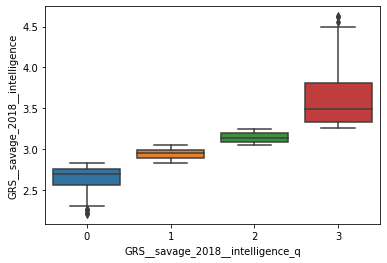

PDBP has 784 individuals
 84 individuals developed cognitive impairment Proportion 0.11
 266 individuals had cognitive impairment at baseline Proportion 0.34
 350 individuals overall met cognitive impairment at baseline or over study Proportion 0.45


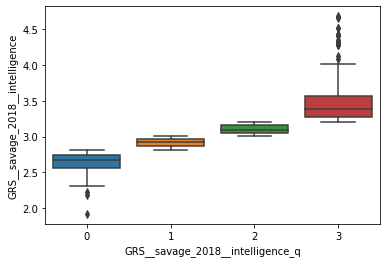

LCC has 63 individuals
 16 individuals developed cognitive impairment Proportion 0.25
 14 individuals had cognitive impairment at baseline Proportion 0.22
 30 individuals overall met cognitive impairment at baseline or over study Proportion 0.48


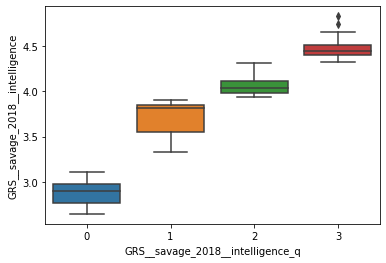

Sure has 246 individuals
 16 individuals developed cognitive impairment Proportion 0.07
 12 individuals had cognitive impairment at baseline Proportion 0.05
 28 individuals overall met cognitive impairment at baseline or over study Proportion 0.11


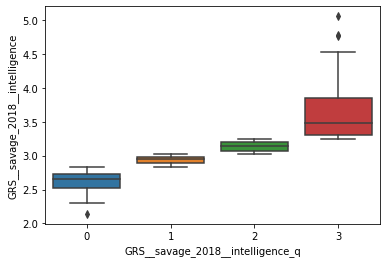

BioFIND has 92 individuals
 0 individuals developed cognitive impairment Proportion 0.0
 16 individuals had cognitive impairment at baseline Proportion 0.17
 16 individuals overall met cognitive impairment at baseline or over study Proportion 0.17


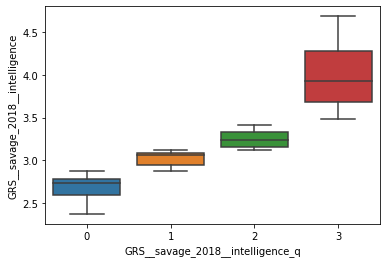

In [167]:
cohorts = ["PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:
    
    #Read in PRS for each cohort
    PRS = pd.read_csv(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab',
                      delimiter = "\t", 
                      index_col = 0)

    #Select relevant columns
    #usecols was not working with index_col
    df = PRS.copy()
    df = df.loc[:, ['GRS__savage_2018__intelligence',
                    'GRS__lee_2018__cognitive_performance',
                    'GRS__lee_2018__educational_attainment',
                    'GRS__davies_2016__reasoning']]

    #Calculate quartiles for each PRS

    #List all column names starting with GRS__
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy = df.copy() #Make copy of original df
    df_copy = df_copy.add_suffix('_q') #Add suffix '_q' (for quartiles to each column name)

    #For each GRS column, calculate the quartiles. This overwrites the old data
    for col in grs_col:
        df_copy[f'{col}_q'] = pd.qcut(df_copy[f'{col}_q'], q=4, labels = False)

    #Merge with original dataframe so we can see both the original PRS and the quartile
    #Merge on the index
    merged = df.merge(df_copy, left_index=True, right_index=True)

    #Read in cognitive impairment data
    cog = pd.read_csv('/home/jupyter/clinical_data_v2-5/cogimpairment_allparticipants.tab', 
                     delimiter = "\t")

    #Join to PRS
    PRS_cog = merged.merge(cog, left_index = True, right_on = 'IID')

    #Save as output
    with open(f'/home/jupyter/Johann_PRS/{cohort}_cogimpairment.tab', 'w') as f:
            f.write(PRS_cog.to_csv(index=True, sep='\t'))
    
    #Remove missing
    PRS_cog_nomiss = PRS_cog.dropna()
    
    
    if len(PRS_cog_nomiss)> 0:
        
        #Print cohort name and number of individuals
        print(f'{cohort} has', len(PRS_cog_nomiss), 'individuals')
    
        print(f'', len(PRS_cog_nomiss[PRS_cog_nomiss.MOCA25_EV == 1]), 'individuals developed cognitive impairment',
         'Proportion', round(len(PRS_cog_nomiss[PRS_cog_nomiss.MOCA25_EV == 1])/len(PRS_cog_nomiss),2))
        print(f'', len(PRS_cog_nomiss[PRS_cog_nomiss.MOCA25_EV == 2]), 'individuals had cognitive impairment at baseline',
         'Proportion', round(len(PRS_cog_nomiss[PRS_cog_nomiss.MOCA25_EV == 2])/len(PRS_cog_nomiss),2))

        print(f'', len(PRS_cog_nomiss[(PRS_cog_nomiss.MOCA25_EV == 1)|(PRS_cog_nomiss.MOCA25_EV == 2)]), 'individuals overall met cognitive impairment at baseline or over study',
             'Proportion', round(len(PRS_cog_nomiss[(PRS_cog_nomiss.MOCA25_EV == 1)|(PRS_cog_nomiss.MOCA25_EV == 2)])/len(PRS_cog_nomiss),2))
    
        #Check quartiles with a boxplot - PRS vs. quartile
        PRS_cog_selected = PRS_cog_nomiss.copy()
        PRS_cog_selected = PRS_cog_selected.loc[:, ['GRS__savage_2018__intelligence', 'GRS__savage_2018__intelligence_q']]

        #Boxplot for GRS intelligence only - just to check the quartiles are calculated correctly
        plt.figure()
        sns.boxplot(x = 'GRS__savage_2018__intelligence_q', y = 'GRS__savage_2018__intelligence',
                data = PRS_cog_selected)
        plt.show()
    
    else:
        continue
            

### Export results to workspace bucket

In [128]:
%%bash

ls /home/jupyter/Johann_PRS/

BioFIND_cogimpairment.tab
BioFIND_PRS_final.tab
HBS_cogimpairment.tab
HBS_PRS_final.tab
LCC_cogimpairment.tab
LCC_MoCA_results.tab
LCC_PRS_final.tab
LDpred2_PRS.tab
PDBP_cogimpairment.tab
PDBP_MoCA_results.tab
PDBP_PRS_final.tab
PPMI_cogimpairment.tab
PPMI_MoCA_results.tab
PPMI_PRS_final.tab
Steady_cogimpairment.tab
Steady_PRS_final.tab
Sure_cogimpairment.tab
Sure_MoCA_results.tab
Sure_PRS_final.tab


In [129]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/*_cogimpairment.tab {WORKSPACE_BUCKET}')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/*_cogimpairment.tab gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181
Copying file:///home/jupyter/Johann_PRS/BioFIND_cogimpairment.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/HBS_cogimpairment.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/LCC_cogimpairment.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/PDBP_cogimpairment.tab [Content-Type=application/octet-stream]...
- [4 files][128.2 KiB/128.2 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///home/jupyter/Johann_PRS/PPMI_cogimpairment.tab [Content-Type=application/octet-stream]...
Copy

## Demographics for Table 1

In [19]:
import statistics

In [168]:
#cohorts = ["PPMI", "PDBP"]
cohorts = ["PPMI", "PDBP", "HBS", "LCC", "Steady", "Sure", "BioFIND"]

for cohort in cohorts:

    #Read in MOCA data (long format)
    moca = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/moca_allparticipants.tab',
                       delimiter = "\t")

    #Read in demographics data to get age at baseline - this is just PD cases
    demo = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_start_end_dx_sex.tab',
                      delimiter = "\t")

    #Read in age at diagnosis data
    age_dx = pd.read_csv(f'/home/jupyter/clinical_data_v2-5/PD_cases_agedx.tab',
                        delimiter = "\t")

    #Read in PRS
    PRS = pd.read_csv(f'/home/jupyter/Johann_PRS/{cohort}_PRS_final.tab',
                         delimiter = "\t", index_col = 0)

    #Read in genetic PCs
    PCs = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/{cohort}.pca.eigenvec',
                     delimiter = "\t")
    #Rename FID column as it is reading in as #FID
    PCs.rename(columns = {'#FID':'FID'}, inplace = True)

    #Read in APOE data
    APOE = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/APOE.raw',
                      delimiter = " ")
    
    ### Severe GBA mutations ###
    
    #Read in severe GBA mutations 
    GBA_severe = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/severe_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_severe = GBA_severe.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of severe GBA mutations
    GBA_severe['Number of severe GBA mutations'] = GBA_severe.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_severe_select = GBA_severe.copy()
    GBA_severe_select = GBA_severe_select.loc[:, ['FID', 'IID', 'Number of severe GBA mutations']]
    
    ### Mild GBA mutations ###
    
    #Read in mild GBA mutations 
    GBA_mild = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/mild_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_mild = GBA_mild.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of mild GBA mutations
    GBA_mild['Number of mild GBA mutations'] = GBA_mild.iloc[:, 2:5].sum(axis = 1)
    
    #Select just total number of mutations column
    GBA_mild_select = GBA_mild.copy()
    GBA_mild_select = GBA_mild_select.loc[:, ['FID', 'IID', 'Number of mild GBA mutations']]
    
    ### Undetermined GBA mutations
    
    #Read in unknown GBA mutations 
    GBA_undetermined = pd.read_csv(f'/home/jupyter/genetic_data_v2-5/undetermined_GBA.recodeA.raw', delimiter = " ")
    #Remove extra columns
    GBA_undetermined = GBA_undetermined.drop(['PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1)

    #Sum number of undetermined GBA mutations
    GBA_undetermined['Number of undetermined GBA mutations'] = GBA_undetermined.iloc[:, 2:75].sum(axis = 1)
    GBA_undetermined[GBA_undetermined['Number of undetermined GBA mutations'] > 0]
    
    #Select just total number of mutations column
    GBA_undetermined_select = GBA_undetermined.copy()
    GBA_undetermined_select = GBA_undetermined_select.loc[:, ['FID', 'IID', 'Number of undetermined GBA mutations']]
    
    
    #Merge moca with demographic data, age at diagnosis data, PRS, APOE and GBA data
    merged1 = moca.merge(demo, left_on = 'participant_id', right_on = 'FID', how = 'inner')
    
    #Make list of dataframes to merge
    data_frames = [merged1, age_dx, PCs, APOE, GBA_severe_select, GBA_mild_select, GBA_undetermined_select]
    
    #Merge all the rest of the dataframes by FID and IID
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['FID', 'IID'],
                                            how='inner'), data_frames)
    
    #Sort by ID and visit month
    df_merged = df_merged.sort_values(by = ['participant_id', 'visit_month'])

    #Select relevant columns
    merged_final = df_merged.copy()
    
    #Sort by ID and visit month
    df_merged = df_merged.sort_values(by = ['participant_id', 'visit_month'])

    #Select relevant columns
    merged_final = df_merged.copy()

    merged_final = merged_final.loc[:, ['participant_id',
                                        'visit_month',
                                        'moca_total_score',
                                        'sex',
                                        'age_at_baseline',
                                        'age_at_diagnosis',
                                        'PC1', 'PC2', 'PC3','PC4',
                                        '19:44908684:T:C_C',
                                        '19:44908822:C:T_T',
                                        'Number of severe GBA mutations', 
                                        'Number of mild GBA mutations',
                                        'Number of undetermined GBA mutations']]

    #Remove rows missing any data
    merged_final_nomiss = merged_final.copy()
    merged_final_nomiss = merged_final_nomiss.dropna()
    
    #If the number of rows is equal to the number of participants (age_dx)
    #This means there is only one observation per participant
    if len(merged_final_nomiss) == 0:
        
        print(f'{cohort} is missing essential clinical or genetic data, N = 0')
        
    elif len(df_merged) == len(PCs):
        
        print(f'{cohort} does not have longitudinal data')

    else:
        print(f'Demographics for {cohort}', merged_final_nomiss.shape, '...')

        #Join with PRS data
        merged_PRS = merged_final_nomiss.merge(PRS, left_on = 'participant_id', right_index = True, how = 'inner')
        
        #Run analysis
            
        #Select unique IDs only
        unique_ids = merged_final_nomiss.drop_duplicates(subset=['participant_id'])
        
        #Number of unique individuals
        print(f'Number of unique individuals =',  len(unique_ids))
        
        #Mean age at baseline
        mean_age_baseline = statistics.mean(unique_ids['age_at_baseline'])
        sd_age_baseline = statistics.stdev(unique_ids['age_at_baseline'])

        print(f'Mean baseline age', round(mean_age_baseline,2), 'SD', round(sd_age_baseline,2))
        
        #Mean age at diagnosis
        mean_age_diagnosis = statistics.mean(unique_ids['age_at_diagnosis'])
        print(f'Mean age at diagnosis', round(mean_age_diagnosis,2))
        
        #Number and proportion of females
        sex_counts = unique_ids.groupby(['sex'])['sex'].count()
        print(f'N female', sex_counts[2])
        print(f'N male', sex_counts[1])
        print(f'Proportion female', round(sex_counts[2]/len(unique_ids),2))
        
        #Length of follow-up in years
        s = merged_final_nomiss.groupby(merged_final_nomiss['participant_id'])['visit_month'].apply(lambda x: x.values[-1]-x.values[0])
        mean_follow_up = statistics.mean(s/12) #This is mean follow-up in months so need to divide by 12 to convert to years
        sd_follow_up = statistics.stdev(s/12) 
        print(f'Mean follow up in years', round(mean_follow_up,2), 'SD', round(sd_follow_up,2))

        #Intervals between visits
        visit_interval = merged_final_nomiss.groupby(merged_final_nomiss['participant_id'])['visit_month'].apply(lambda x: x.diff())
        visit_interval2 = visit_interval.dropna()/12 #Remove missing rows and divide by 12 to get time in years
        mean_visit_interval = statistics.mean(visit_interval2)
        sd_visit_interval = statistics.stdev(visit_interval2)
        print(f'Mean visit interval in years', round(mean_visit_interval,2), 'SD', round(sd_visit_interval,2))

        #Baseline MoCA score
        #Visit month is -1 or 0
        #We are including -1 which is technically the screening visit - some studies have only done the MOCA at screening
        baseline = merged_final_nomiss[(merged_final_nomiss['visit_month'] == -1) | (merged_final_nomiss['visit_month'] == 0)]
        mean_BL_MOCA = statistics.mean(baseline['moca_total_score'])
        sd_BL_MOCA = statistics.stdev(baseline['moca_total_score'])
        print(f'Mean baseline MoCA score', round(mean_BL_MOCA,2), 'SD', round(sd_BL_MOCA,2))
        
        
        #Export data
        with open(f'/home/jupyter/Johann_PRS/{cohort}_demographics.tab', 'w') as f:
            f.write(merged_final_nomiss.to_csv(index=True, sep='\t'))

Demographics for PPMI (2755, 15) ...
Number of unique individuals = 465
Mean baseline age 61.77 SD 9.71
Mean age at diagnosis 61.29
N female 165
N male 300
Proportion female 0.35
Mean follow up in years 5.23 SD 2.85
Mean visit interval in years 1.06 SD 0.28
Mean baseline MoCA score 27.12 SD 2.32
Demographics for PDBP (1825, 15) ...
Number of unique individuals = 784
Mean baseline age 64.49 SD 9.01
Mean age at diagnosis 58.77
N female 283
N male 501
Proportion female 0.36
Mean follow up in years 1.39 SD 1.6
Mean visit interval in years 1.05 SD 0.24
Mean baseline MoCA score 25.37 SD 3.51
HBS is missing essential clinical or genetic data, N = 0
Demographics for LCC (158, 15) ...
Number of unique individuals = 63
Mean baseline age 68.03 SD 9.74
Mean age at diagnosis 60.24
N female 22
N male 41
Proportion female 0.35
Mean follow up in years 2.22 SD 1.92
Mean visit interval in years 1.47 SD 0.7
Mean baseline MoCA score 25.41 SD 4.42
Steady is missing essential clinical or genetic data, N = 0

Export results to workspace bucket

In [169]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/Johann_PRS/*_demographics.tab {WORKSPACE_BUCKET}')

Executing: gsutil -u manuela-norway cp -r /home/jupyter/Johann_PRS/*_demographics.tab gs://fc-2f037edd-3b8a-43cc-8283-b6704707b181
Copying file:///home/jupyter/Johann_PRS/LCC_demographics.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/PDBP_demographics.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/PPMI_demographics.tab [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/Johann_PRS/Sure_demographics.tab [Content-Type=application/octet-stream]...
- [4 files][478.5 KiB/478.5 KiB]                                                
Operation completed over 4 objects/478.5 KiB.                                    


## Provenance

In [170]:
import datetime
print(datetime.datetime.now())

2022-11-01 17:56:45.518051


In [171]:
!pip freeze

et-xmlfile==1.1.0
openpyxl==3.0.10
